### Notebook Overview

1. **Preprocessing Images**:
   - The images in the dataset come in different sizes. We will preprocess them by cropping to dimensions divisible by 256 to ensure uniformity.

2. **Handling Mask Colors**:
   - The mask images contain HEXA codes that need to be converted to RGB format for proper representation.

3. **One-Hot Encoding**:
   - Since this is a multi-class segmentation problem, we will convert the RGB values into one-hot encoded format for model training.

4. **Reconversion of Predicted Images**:
   - After prediction, the images will need to be converted back to their original RGB colors.

We will use the **patchify** library for image cropping and extracting patches. The patch size will be (256, 256), meaning we need to divide the original images into tiles of (n_rows, n_cols) that are divisible by 256.

The **U-Net architecture** will be implemented for this segmentation problem using TensorFlow's Keras API.

In [1]:
# Importing required libraries
!pip install patchify

# Standard libraries
from pathlib import Path
from patchify import patchify
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# TensorFlow and Keras libraries
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import (
    Input, 
    Conv2D, 
    BatchNormalization, 
    ReLU, 
    SpatialDropout2D, 
    MaxPooling2D, 
    Conv2DTranspose, 
    concatenate
)

# Metrics and Loss functions
from tensorflow.keras.metrics import OneHotIoU, Recall, Precision
from tensorflow.keras.losses import CategoricalFocalCrossentropy, Dice
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# Define the directory containing the dataset
directory = Path('/kaggle/input/semantic-segmentation-of-aerial-imagery')
scaler = MinMaxScaler()
patch_size = 256
image_dataset = []

# Walk through the directory to find images
for path in directory.glob('**/images'):
    images = sorted(path.glob('*.jpg'))  
    print(f'Found images in: {path.name}')
    print([img.name for img in images])
    
    for image_path in images:
        image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
        
        if image is None:
            print(f'Error loading image: {image_path}')
            continue  # Skip if image is not loaded properly
        
        # Resize the image to be divisible by the patch size
        x_size = (image.shape[1] // patch_size) * patch_size
        y_size = (image.shape[0] // patch_size) * patch_size
        image = Image.fromarray(image).crop((0, 0, x_size, y_size))
        image = np.array(image)

        # Extract patches from each image with overlap
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

        # Normalize each patch and append to dataset
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i, j, :, :]
                single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                
                single_patch_img = single_patch_img[0]
                image_dataset.append(single_patch_img)


Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Found images in: images
['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.j

In [3]:
# Define the patch size and initialize the mask dataset
patch_size = 256
mask_dataset = []

# Walk through the directory to find masks
for path in directory.glob('**/masks'):
    masks = sorted(path.glob('*.png'))  # List all png masks in sorted order
    print(f'Found masks in: {path.name}')
    print([mask.name for mask in masks])

    for mask_path in masks:
        mask = cv2.imread(str(mask_path), cv2.IMREAD_COLOR)

        if mask is None:
            print(f'Error loading mask: {mask_path}')
            continue  # Skip if the mask is not loaded properly

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        x_size = (mask.shape[1] // patch_size) * patch_size
        y_size = (mask.shape[0] // patch_size) * patch_size
        mask = Image.fromarray(mask).crop((0, 0, x_size, y_size))
        mask = np.array(mask)

        # Extract patches from each mask with overlap
        patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

        # Append each single patch to the mask dataset
        for row in range(patches_mask.shape[0]):
            for col in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[row, col, :, :]

                single_patch_mask = single_patch_mask[0]
                mask_dataset.append(single_patch_mask)


Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'image_part_005.png', 'image_part_006.png', 'image_part_007.png', 'image_part_008.png', 'image_part_009.png']
Found masks in: masks
['image_part_001.png', 'image_part_002.png', 'image_part_003.png', 'image_part_004.png', 'imag

In [4]:
#converting the image and masks lists into arrays
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

# Print shapes of the datasets
print(image_dataset.shape, mask_dataset.shape)

(1305, 256, 256, 3) (1305, 256, 256, 3)


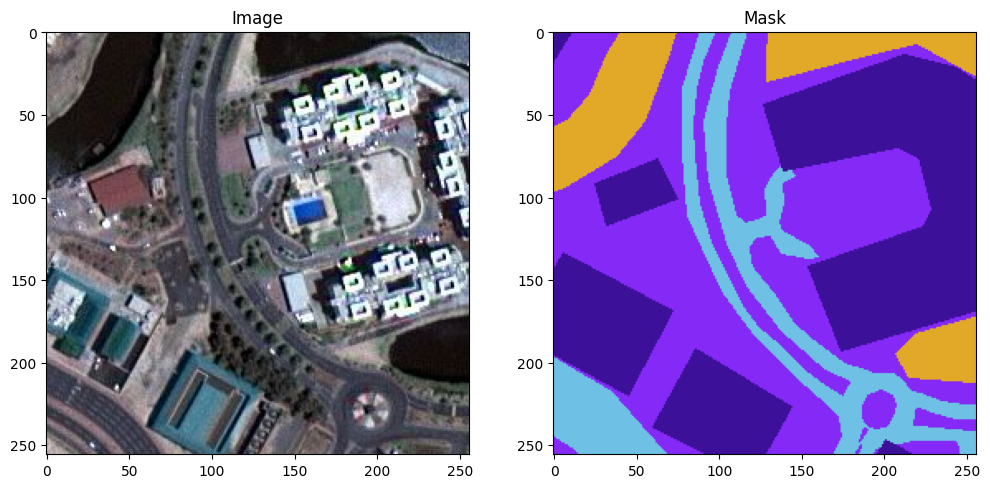

In [5]:
# Check the consistency between the images and masks 
check_number = np.random.randint(0, len(image_dataset))

# Create a figure to display the selected image and its corresponding mask
fig = plt.figure(figsize=(12, 10))
ax = fig.subplot_mosaic("""AB""")
ax['A'].imshow(image_dataset[check_number])
ax['A'].set_title('Image')
ax['B'].imshow(mask_dataset[check_number])
ax['B'].set_title('Mask')
plt.show()


In [6]:
# Define hexadecimal colors for each class
class_colors_hex = {
    'Building': '#3C1098',
    'Land': '#8429F6',
    'Road': '#6EC1E4',
    'Vegetation': '#FEDD3A',
    'Water': '#E2A929',
    'Unlabeled': '#9B9B9B'
}

# Function to convert hexadecimal colors to RGB integer values
def hex_to_int(hex_color):
    hex_color = hex_color.lstrip('#')  # Remove the '#' from the beginning
    return np.array(tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4)))  # Convert to RGB

# Create a dictionary mapping class names to their RGB integer values
class_colors = {key: hex_to_int(value) for key, value in class_colors_hex.items()}

# Print the RGB values for each class
print(class_colors)


{'Building': array([ 60,  16, 152]), 'Land': array([132,  41, 246]), 'Road': array([110, 193, 228]), 'Vegetation': array([254, 221,  58]), 'Water': array([226, 169,  41]), 'Unlabeled': array([155, 155, 155])}


In [7]:
# Function to convert RGB colors in the label masks to integer labels
def rgb_to_2D_label(label):
    """
    Convert RGB mask to integer labels based on predefined class colors.

    Args:
        label (np.ndarray): Input mask in RGB format.

    Returns:
        np.ndarray: Segmentation mask with integer labels.
    """
    # Initialize a label mask with zeros
    label_seg = np.zeros(label.shape[:-1], dtype=np.uint8)
    
    # Assign integer labels based on RGB values
    for idx, color in enumerate(class_colors.values()):
        label_seg[np.all(label == color, axis=-1)] = idx  # Match the color

    return label_seg

# Convert all masks in mask_dataset to integer labels
labels = np.array([rgb_to_2D_label(mask) for mask in mask_dataset])  
labels = np.expand_dims(labels, axis=3)  # Add an extra dimension

# Display unique labels and the shape of the labels array
print("Unique labels in label dataset are: ", np.unique(labels))
print("Shape of the labels is: ", labels.shape)


Unique labels in label dataset are:  [0 1 2 3 4 5]
Shape of the labels is:  (1305, 256, 256, 1)


In [8]:
# Converting labels to categories using one-hot encoding
num_classes = len(class_colors)
labels_categ = to_categorical(labels, num_classes=num_classes)  

# Display the shape of the one-hot encoded labels
print("Shape of one-hot encoded labels:", labels_categ.shape)


Shape of one-hot encoded labels: (1305, 256, 256, 6)


In [9]:
# Splitting the data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_categ, test_size=0.20, random_state=42)

# Further splitting the test data into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Outputting the shapes of each split
print(f'Shape of training data: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape of validation data: X_val: {X_val.shape}, y_val: {y_val.shape}')
print(f'Shape of test data: X_test: {X_test.shape}, y_test: {y_test.shape}')

Shape of training data: X_train: (1044, 256, 256, 3), y_train: (1044, 256, 256, 6)
Shape of validation data: X_val: (130, 256, 256, 3), y_val: (130, 256, 256, 6)
Shape of test data: X_test: (131, 256, 256, 3), y_test: (131, 256, 256, 6)


In [10]:
# Data Augmentation
# Creating the data generators with specified augmentation parameters
batch_size = 32

data_gen_args = dict(
    rotation_range=45.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,  
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)


# Instantiate ImageDataGenerator for images and labels
image_data_gen = ImageDataGenerator(**data_gen_args)
label_data_gen = ImageDataGenerator(**data_gen_args)

def data_generator(image_data_gen, label_data_gen, X_train, y_train, batch_size):
    """
    Generator function that yields batches of augmented image and label data.

    Parameters:
    - image_data_gen: Augmentation configuration for images.
    - label_data_gen: Augmentation configuration for labels.
    - X_train: Training images.
    - y_train: Training labels.
    - batch_size: Number of samples per batch.

    Yields:
    - Tuple of augmented image and label batches.
    """
    # Create generators for images and labels
    image_generator = image_data_gen.flow(X_train, batch_size=batch_size, seed=42)
    label_generator = label_data_gen.flow(y_train, batch_size=batch_size, seed=42)

    while True:
        # Get the next batch of images and labels
        X_batch = next(image_generator)
        y_batch = next(label_generator)

        yield X_batch, y_batch

# Initialize the training generator
train_generator = data_generator(image_data_gen, label_data_gen, X_train, y_train, batch_size)


In [11]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred):
    """
    Dice Loss for multi-class segmentation.
    """
    numerator = 2 * K.sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = K.sum(y_true + y_pred, axis=[1, 2, 3])
    return 1 - numerator / (denominator + K.epsilon())

def combined_dice_focal_loss(y_true, y_pred):
    """
    Combined Dice Loss and Focal Loss for multi-class segmentation.
    """
    focal_loss = CategoricalCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return focal_loss + dice

In [12]:
from tensorflow.keras.metrics import MeanIoU, Precision, Recall

metrics = [
    MeanIoU(num_classes=6),  # Replace '6' with the number of classes in your segmentation task
    Precision(),
    Recall()
]

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    Activation,
    MaxPooling2D,
    UpSampling2D,
    concatenate,
    AveragePooling2D,
    DepthwiseConv2D
)


def atrous_spatial_pyramid_pooling(inputs, filters=256):
    """
    Atrous Spatial Pyramid Pooling (ASPP) block.
    
    Args:
    - inputs: Input tensor.
    - filters: Number of filters for convolution layers.
    
    Returns:
    - Output tensor from ASPP block.
    """
    shape = inputs.shape[1:3]

    # 1x1 convolution
    conv_1x1 = Conv2D(filters, (1, 1), padding="same", kernel_initializer="he_normal")(inputs)
    conv_1x1 = BatchNormalization()(conv_1x1)
    conv_1x1 = Activation("relu")(conv_1x1)

    # Atrous convolutions with different rates
    conv_3x3_r6 = Conv2D(filters, (3, 3), padding="same", dilation_rate=6, kernel_initializer="he_normal")(inputs)
    conv_3x3_r6 = BatchNormalization()(conv_3x3_r6)
    conv_3x3_r6 = Activation("relu")(conv_3x3_r6)

    conv_3x3_r12 = Conv2D(filters, (3, 3), padding="same", dilation_rate=12, kernel_initializer="he_normal")(inputs)
    conv_3x3_r12 = BatchNormalization()(conv_3x3_r12)
    conv_3x3_r12 = Activation("relu")(conv_3x3_r12)

    conv_3x3_r18 = Conv2D(filters, (3, 3), padding="same", dilation_rate=18, kernel_initializer="he_normal")(inputs)
    conv_3x3_r18 = BatchNormalization()(conv_3x3_r18)
    conv_3x3_r18 = Activation("relu")(conv_3x3_r18)

    # Image pooling
    image_pooling = AveragePooling2D(pool_size=(shape[0], shape[1]))(inputs)
    image_pooling = Conv2D(filters, (1, 1), padding="same", kernel_initializer="he_normal")(image_pooling)
    image_pooling = BatchNormalization()(image_pooling)
    image_pooling = Activation("relu")(image_pooling)
    image_pooling = UpSampling2D(size=(shape[0], shape[1]), interpolation="bilinear")(image_pooling)

    # Concatenate all branches
    aspp = concatenate([conv_1x1, conv_3x3_r6, conv_3x3_r12, conv_3x3_r18, image_pooling])

    # Reduce dimensions
    aspp = Conv2D(filters, (1, 1), padding="same", kernel_initializer="he_normal")(aspp)
    aspp = BatchNormalization()(aspp)
    aspp = Activation("relu")(aspp)

    return aspp


def deeplabv3plus(input_shape=(256, 256, 3), num_classes=6):
    """
    DeepLabV3+ implementation for semantic segmentation.

    Args:
    - input_shape: Shape of input image.
    - num_classes: Number of segmentation classes.

    Returns:
    - model: A compiled DeepLabV3+ Keras model.
    """
    inputs = Input(input_shape)

    # Base model: ResNet50 without top layers
    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    # Encoder features
    high_level_features = base_model.get_layer("conv4_block6_out").output

    # ASPP block
    aspp = atrous_spatial_pyramid_pooling(high_level_features)

    # Decoder
    low_level_features = base_model.get_layer("conv2_block3_out").output
    low_level_features = Conv2D(48, (1, 1), padding="same", kernel_initializer="he_normal")(low_level_features)
    low_level_features = BatchNormalization()(low_level_features)
    low_level_features = Activation("relu")(low_level_features)

    # Upsample and concatenate
    upsampled_aspp = UpSampling2D(size=(4, 4), interpolation="bilinear")(aspp)
    concatenated = concatenate([upsampled_aspp, low_level_features])

    # Decoder convolutions
    decoder = Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal")(concatenated)
    decoder = BatchNormalization()(decoder)
    decoder = Activation("relu")(decoder)
    decoder = Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal")(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation("relu")(decoder)

    # Final upsampling
    outputs = UpSampling2D(size=(4, 4), interpolation="bilinear")(decoder)
    outputs = Conv2D(num_classes, (1, 1), activation="softmax")(outputs)

    # Compile model
    model = Model(inputs, outputs)

    return model

# Initialize the DeepLabV3+ model
deeplabv3plus_model = deeplabv3plus(input_shape=(256, 256, 3), num_classes=6)

# Compile the model with the updated loss and metrics
deeplabv3plus_model.compile(optimizer="adam", loss=combined_dice_focal_loss, metrics=metrics)

# Display model summary
deeplabv3plus_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 17,833,590 (68.03 MB)

 Trainable params: 17,798,806 (67.90 MB)

 Non-trainable params: 34,784 (135.88 KB)

In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

# Define metric functions
def jaccard_coeff(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(-1))
    union = tf.reduce_sum(y_true + y_pred, axis=(-1))
    jac = (intersection + smooth) / (union - intersection + smooth)
    return jac

# Metrics for model evaluation
# OneHotIoU measures the intersection over union for each class
metrics = [OneHotIoU(num_classes, target_class_ids=[0,1,2,3,4]), Precision(), Recall(), jaccard_coeff]

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(-1))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(-1))
    dice = (2 * intersection + smooth) / (sum_ + smooth)
    return tf.reduce_mean(dice)

def segmentation_accuracy(y_true, y_pred):
    y_pred = tf.round(y_pred)
    correct_predictions = tf.equal(y_true, y_pred)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

# Define combined loss function (Dice + Focal)
focal = CategoricalFocalCrossentropy(alpha=0.5, gamma=1)
dice = Dice()

def combined_dice_focal_loss(y_true, y_pred):
    dice_loss = dice(y_true, y_pred)
    focal_loss = focal(y_true, y_pred)
    total_loss = focal_loss + dice_loss
    return total_loss

# Update metrics
metrics = [
    OneHotIoU(num_classes, target_class_ids=[0,1,2,3,4]),
    Precision(),
    Recall(),
    jaccard_coeff,
    dice_score,
    segmentation_accuracy
]

# Compile and train the model
# Compile the model with the updated loss and metrics
deeplabv3plus_model.compile(optimizer="adam", loss=combined_dice_focal_loss, metrics=metrics)
history = deeplabv3plus_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=50,
    validation_data=(X_val, y_val)
)

# Plotting function for all metrics
def plot_all_metrics(history):
    metrics_map = {
        'loss': 'Loss',
        'dice_score': 'Dice Score',
        'jaccard_coeff': 'Jaccard Coefficient',
        'one_hot_io_u_1': 'Mean IoU',
        'precision_2': 'Precision',
        'recall_2': 'Recall',
        'segmentation_accuracy': 'Accuracy'
    }

    for metric_key, label in metrics_map.items():
        try:
            plt.plot(history.history[metric_key], label=f'Training {label}')
            plt.plot(history.history[f'val_{metric_key}'], label=f'Validation {label}')
            plt.xlabel('Epochs')
            plt.ylabel(label)
            plt.legend()
            plt.title(f'{label} over Epochs')
            plt.show()
        except KeyError:
            print(f"Metric '{metric_key}' not found in history. Please check the available keys.")


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1044, 256, 256, 6) (6 channels).
  warnings.warn(


Epoch 1/50


I0000 00:00:1732548949.231890      87 service.cc:145] XLA service 0x7d6f24003e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732548949.231958      87 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-11-25 15:36:17.968480: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k5=1,k6=0,k7=1,k10=2} for conv (f32[10368,1024,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[10368,256,1,1]{3,2,1,0}, f32[256,1024,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-25 15:36:18.074409: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.106028684s
Trying algorithm eng

32/32 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - dice_score: 0.6030 - jaccard_coeff: 0.5303 - loss: 0.8092 - one_hot_io_u_1: 0.4341 - precision_2: 0.7647 - recall_2: 0.5900 - segmentation_accuracy: 0.8985 - val_dice_score: 0.1182 - val_jaccard_coeff: 0.1450 - val_loss: 7.7059 - val_one_hot_io_u_1: 0.0337 - val_precision_2: 0.1454 - val_recall_2: 0.1454 - val_segmentation_accuracy: 0.7061
Epoch 2/50


2024-11-25 15:37:55.323104: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng25{k2=1,k3=0} for conv (f32[6480,1024,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[6480,256,1,1]{3,2,1,0}, f32[256,1024,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-25 15:37:55.997627: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.6747046s
Trying algorithm eng25{k2=1,k3=0} for conv (f32[6480,1024,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[6480,256,1,1]{3,2,1,0}, f32[256,1024,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_ba

32/32 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - dice_score: 0.7371 - jaccard_coeff: 0.6723 - loss: 0.5024 - one_hot_io_u_1: 0.5922 - precision_2: 0.8434 - recall_2: 0.7498 - segmentation_accuracy: 0.9291 - val_dice_score: 0.5642 - val_jaccard_coeff: 0.4660 - val_loss: 1.6350 - val_one_hot_io_u_1: 0.1155 - val_precision_2: 0.5730 - val_recall_2: 0.5701 - val_segmentation_accuracy: 0.8748
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - dice_score: 0.7701 - jaccard_coeff: 0.7062 - loss: 0.4355 - one_hot_io_u_1: 0.6510 - precision_2: 0.8682 - recall_2: 0.7856 - segmentation_accuracy: 0.9391 - val_dice_score: 0.5867 - val_jaccard_coeff: 0.5068 - val_loss: 1.6692 - val_one_hot_io_u_1: 0.1150 - val_precision_2: 0.5698 - val_recall_2: 0.5689 - val_segmentation_accuracy: 0.8736
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - dice_score: 0.7846 - jaccard_coeff: 0.7271 - loss: 0.3979 - one_hot_io_u_1: 0.6638 - precision_2: 0.8752 - recall_2: 0.7987 - segmentation_accuracy: 0.9417 - val_dice_scor

In [15]:
deeplabv3plus_model.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - dice_score: 0.8043 - jaccard_coeff: 0.7621 - loss: 0.4662 - one_hot_io_u_1: 0.6786 - precision_2: 0.8420 - recall_2: 0.8228 - segmentation_accuracy: 0.9446  


[0.4472077190876007,
 0.6849215626716614,
 0.846329391002655,
 0.8279217481613159,
 0.7698923349380493,
 0.8118788599967957,
 0.9459840655326843]

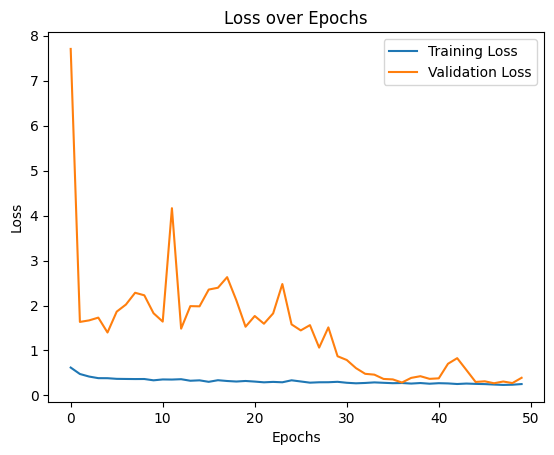

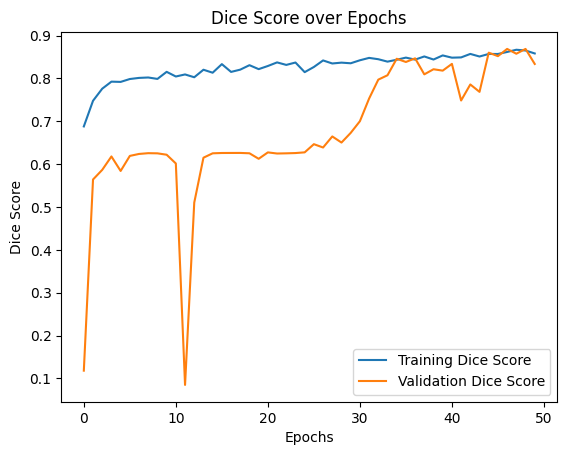

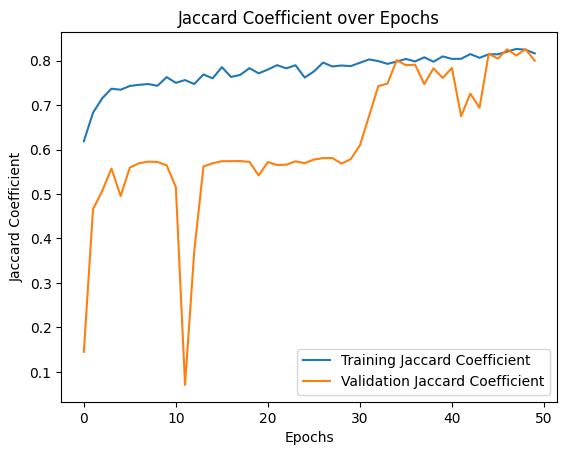

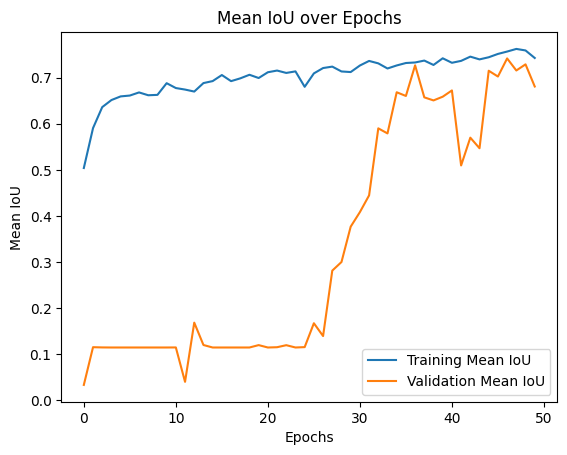

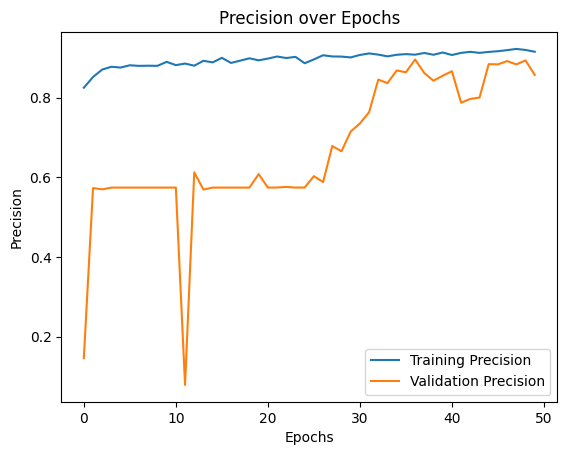

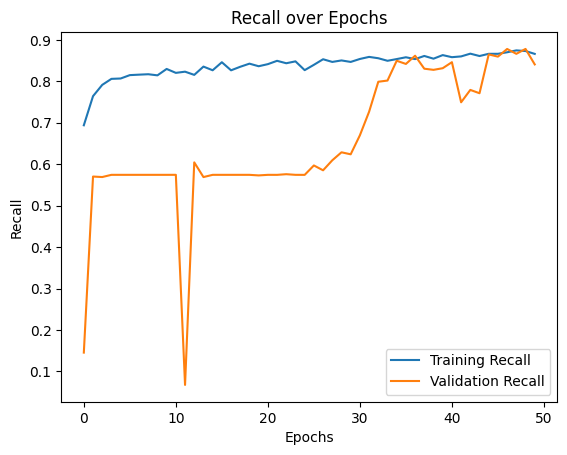

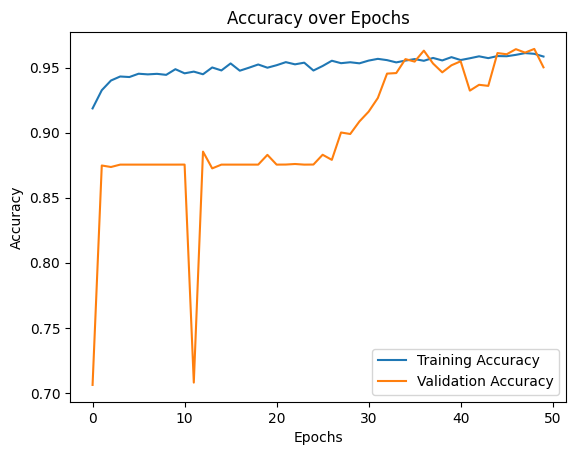

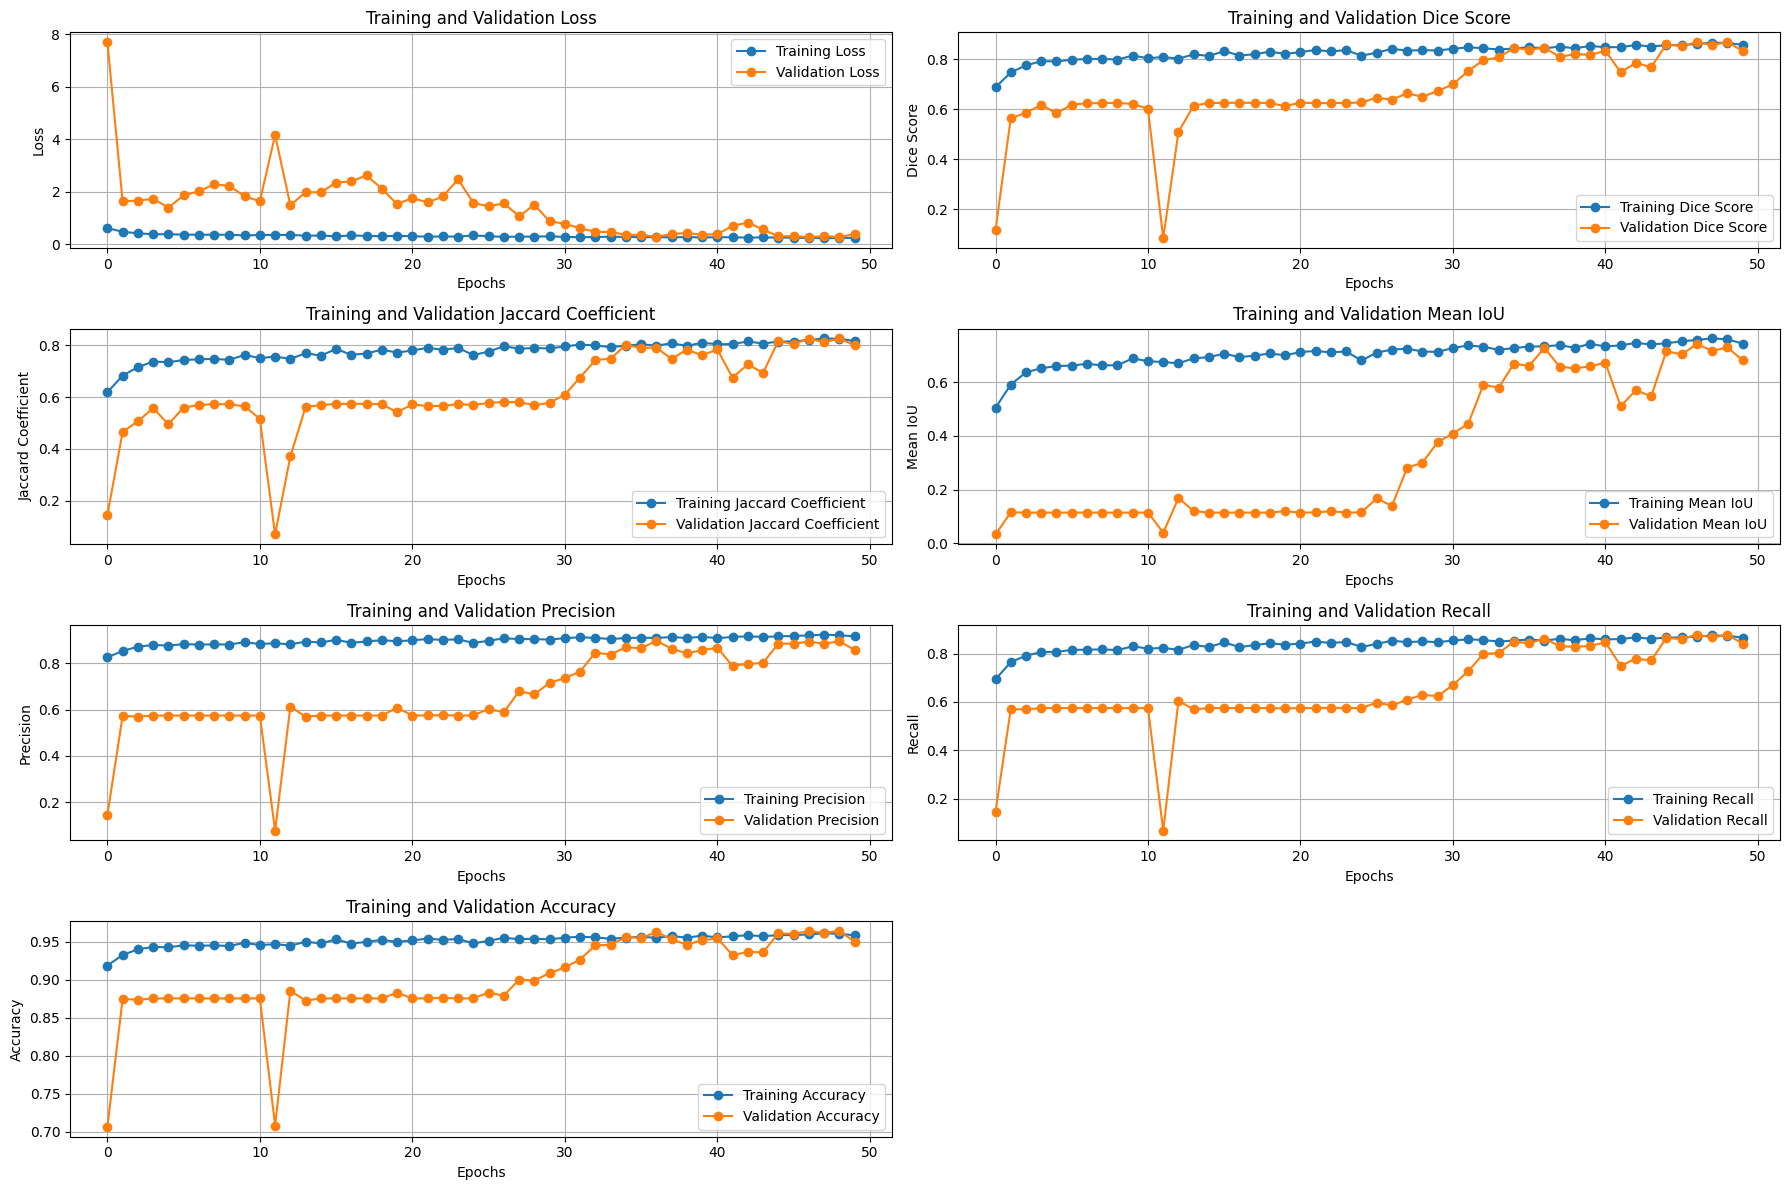

In [20]:
from tensorflow.keras.metrics import OneHotIoU, Precision, Recall
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

# Define custom Jaccard Coefficient
def jaccard_coeff(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    jac = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(jac)

# Metrics for model evaluation
num_classes = 6  # Update based on your dataset
metrics = [
    OneHotIoU(num_classes=num_classes, target_class_ids=list(range(num_classes))),
    Precision(),
    Recall(),
    jaccard_coeff
]

# Metrics for model evaluation
# OneHotIoU measures the intersection over union for each class
metrics = [OneHotIoU(num_classes, target_class_ids=[0,1,2,3,4]), Precision(), Recall(), jaccard_coeff]

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(-1))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(-1))
    dice = (2 * intersection + smooth) / (sum_ + smooth)
    return tf.reduce_mean(dice)

def segmentation_accuracy(y_true, y_pred):
    y_pred = tf.round(y_pred)
    correct_predictions = tf.equal(y_true, y_pred)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

# Define combined loss function (Dice + Focal)
focal = CategoricalFocalCrossentropy(alpha=0.5, gamma=1)
dice = Dice()

def combined_dice_focal_loss(y_true, y_pred):
    dice_loss = dice(y_true, y_pred)
    focal_loss = focal(y_true, y_pred)
    total_loss = focal_loss + dice_loss
    return total_loss

# Update metrics
metrics = [
    OneHotIoU(num_classes, target_class_ids=[0,1,2,3,4]),
    Precision(),
    Recall(),
    jaccard_coeff,
    dice_score,
    segmentation_accuracy
]

# Compile and train the model
#deeplabv3plus_model.compile(optimizer="adam", loss=combined_dice_focal_loss, metrics=metrics)
#history = deeplabv3plus_model.fit( train_generator, steps_per_epoch=len(X_train) // batch_size, epochs=50, validation_data=(X_val, y_val))
# Check available keys in history
#print(history.history.keys())

# Plotting function for all metrics
def plot_all_metrics(history):
    metrics_map = {
        'loss': 'Loss',
        'dice_score': 'Dice Score',
        'jaccard_coeff': 'Jaccard Coefficient',
        'one_hot_io_u_1': 'Mean IoU',
        'precision_2': 'Precision',
        'recall_2': 'Recall',
        'segmentation_accuracy': 'Accuracy'
    }

    for metric_key, label in metrics_map.items():
        try:
            plt.plot(history.history[metric_key], label=f'Training {label}')
            plt.plot(history.history[f'val_{metric_key}'], label=f'Validation {label}')
            plt.xlabel('Epochs')
            plt.ylabel(label)
            plt.legend()
            plt.title(f'{label} over Epochs')
            plt.show()
        except KeyError:
            print(f"Metric '{metric_key}' not found in history. Please check the available keys.")

# Call the plotting function
plot_all_metrics(history)


import matplotlib.pyplot as plt

def plot_training_metrics(history):
    """
    Plots training and validation metrics over epochs.

    Parameters:
    - history: Training history object returned by the `model.fit()` method.
    """
    metrics_map = {
        'loss': 'Loss',
        'dice_score': 'Dice Score',
        'jaccard_coeff': 'Jaccard Coefficient',
        'one_hot_io_u_1': 'Mean IoU',
        'precision_2': 'Precision',
        'recall_2': 'Recall',
        'segmentation_accuracy': 'Accuracy'
    }
    
    plt.figure(figsize=(18, 12))

    for idx, (metric_key, metric_name) in enumerate(metrics_map.items(), 1):
        plt.subplot(4, 2, idx)
        plt.plot(history.history[metric_key], label=f'Training {metric_name}', marker='o')
        plt.plot(history.history[f'val_{metric_key}'], label=f'Validation {metric_name}', marker='o')
        plt.title(f'Training and Validation {metric_name}')
        plt.xlabel('Epochs')
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function to plot metrics
plot_training_metrics(history)

In [16]:
print(history.history.keys())

dict_keys(['dice_score', 'jaccard_coeff', 'loss', 'one_hot_io_u_1', 'precision_2', 'recall_2', 'segmentation_accuracy', 'val_dice_score', 'val_jaccard_coeff', 'val_loss', 'val_one_hot_io_u_1', 'val_precision_2', 'val_recall_2', 'val_segmentation_accuracy'])


dict_keys(['dice_score', 'jaccard_coeff', 'loss', 'one_hot_io_u_1', 'precision_2', 'recall_2', 'segmentation_accuracy', 'val_dice_score', 'val_jaccard_coeff', 'val_loss', 'val_one_hot_io_u_1', 'val_precision_2', 'val_recall_2', 'val_segmentation_accuracy'])


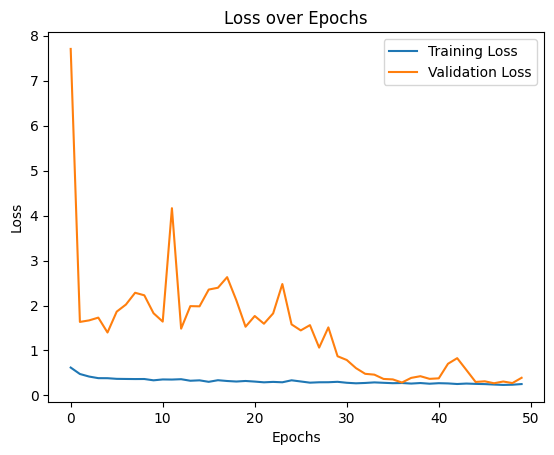

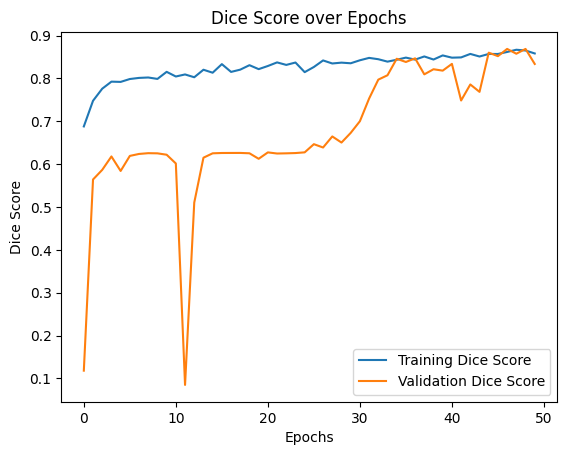

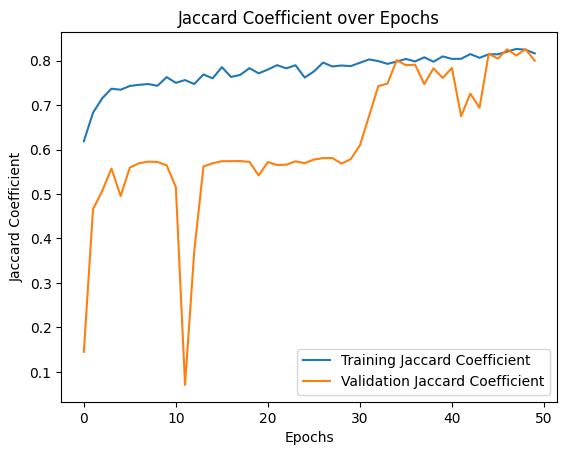

Metric 'one_hot_io_u_7' not found in history. Please check the available keys.
Metric 'precision_8' not found in history. Please check the available keys.
Metric 'recall_8' not found in history. Please check the available keys.


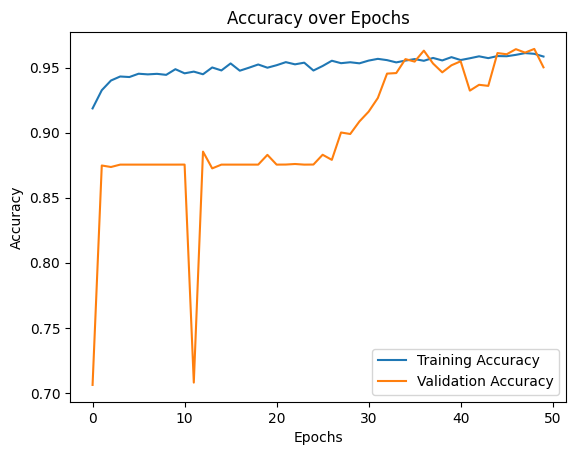

In [21]:
from tensorflow.keras.metrics import OneHotIoU, Precision, Recall
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

# Define custom Jaccard Coefficient
def jaccard_coeff(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    jac = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(jac)

# Metrics for model evaluation
num_classes = 6  # Update based on your dataset
metrics = [
    OneHotIoU(num_classes=num_classes, target_class_ids=list(range(num_classes))),
    Precision(),
    Recall(),
    jaccard_coeff
]

# Metrics for model evaluation
# OneHotIoU measures the intersection over union for each class
metrics = [OneHotIoU(num_classes, target_class_ids=[0,1,2,3,4]), Precision(), Recall(), jaccard_coeff]

def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(-1))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(-1))
    dice = (2 * intersection + smooth) / (sum_ + smooth)
    return tf.reduce_mean(dice)

def segmentation_accuracy(y_true, y_pred):
    y_pred = tf.round(y_pred)
    correct_predictions = tf.equal(y_true, y_pred)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

# Define combined loss function (Dice + Focal)
focal = CategoricalFocalCrossentropy(alpha=0.5, gamma=1)
dice = Dice()

def combined_dice_focal_loss(y_true, y_pred):
    dice_loss = dice(y_true, y_pred)
    focal_loss = focal(y_true, y_pred)
    total_loss = focal_loss + dice_loss
    return total_loss

# Update metrics
metrics = [
    OneHotIoU(num_classes, target_class_ids=[0,1,2,3,4]),
    Precision(),
    Recall(),
    jaccard_coeff,
    dice_score,
    segmentation_accuracy
]

# Compile and train the model
#deeplabv3plus_model.compile(optimizer="adam", loss=combined_dice_focal_loss, metrics=metrics)
#history = deeplabv3plus_model.fit( train_generator, steps_per_epoch=len(X_train) // batch_size, epochs=50, validation_data=(X_val, y_val))
# Check available keys in history
print(history.history.keys())

# Plotting function for all metrics
def plot_all_metrics(history):
    metrics_map = {
        'loss': 'Loss',
        'dice_score': 'Dice Score',
        'jaccard_coeff': 'Jaccard Coefficient',
        'one_hot_io_u_7': 'Mean IoU',
        'precision_8': 'Precision',
        'recall_8': 'Recall',
        'segmentation_accuracy': 'Accuracy'
    }

    for metric_key, label in metrics_map.items():
        try:
            plt.plot(history.history[metric_key], label=f'Training {label}')
            plt.plot(history.history[f'val_{metric_key}'], label=f'Validation {label}')
            plt.xlabel('Epochs')
            plt.ylabel(label)
            plt.legend()
            plt.title(f'{label} over Epochs')
            plt.show()
        except KeyError:
            print(f"Metric '{metric_key}' not found in history. Please check the available keys.")

# Call the plotting function
plot_all_metrics(history)

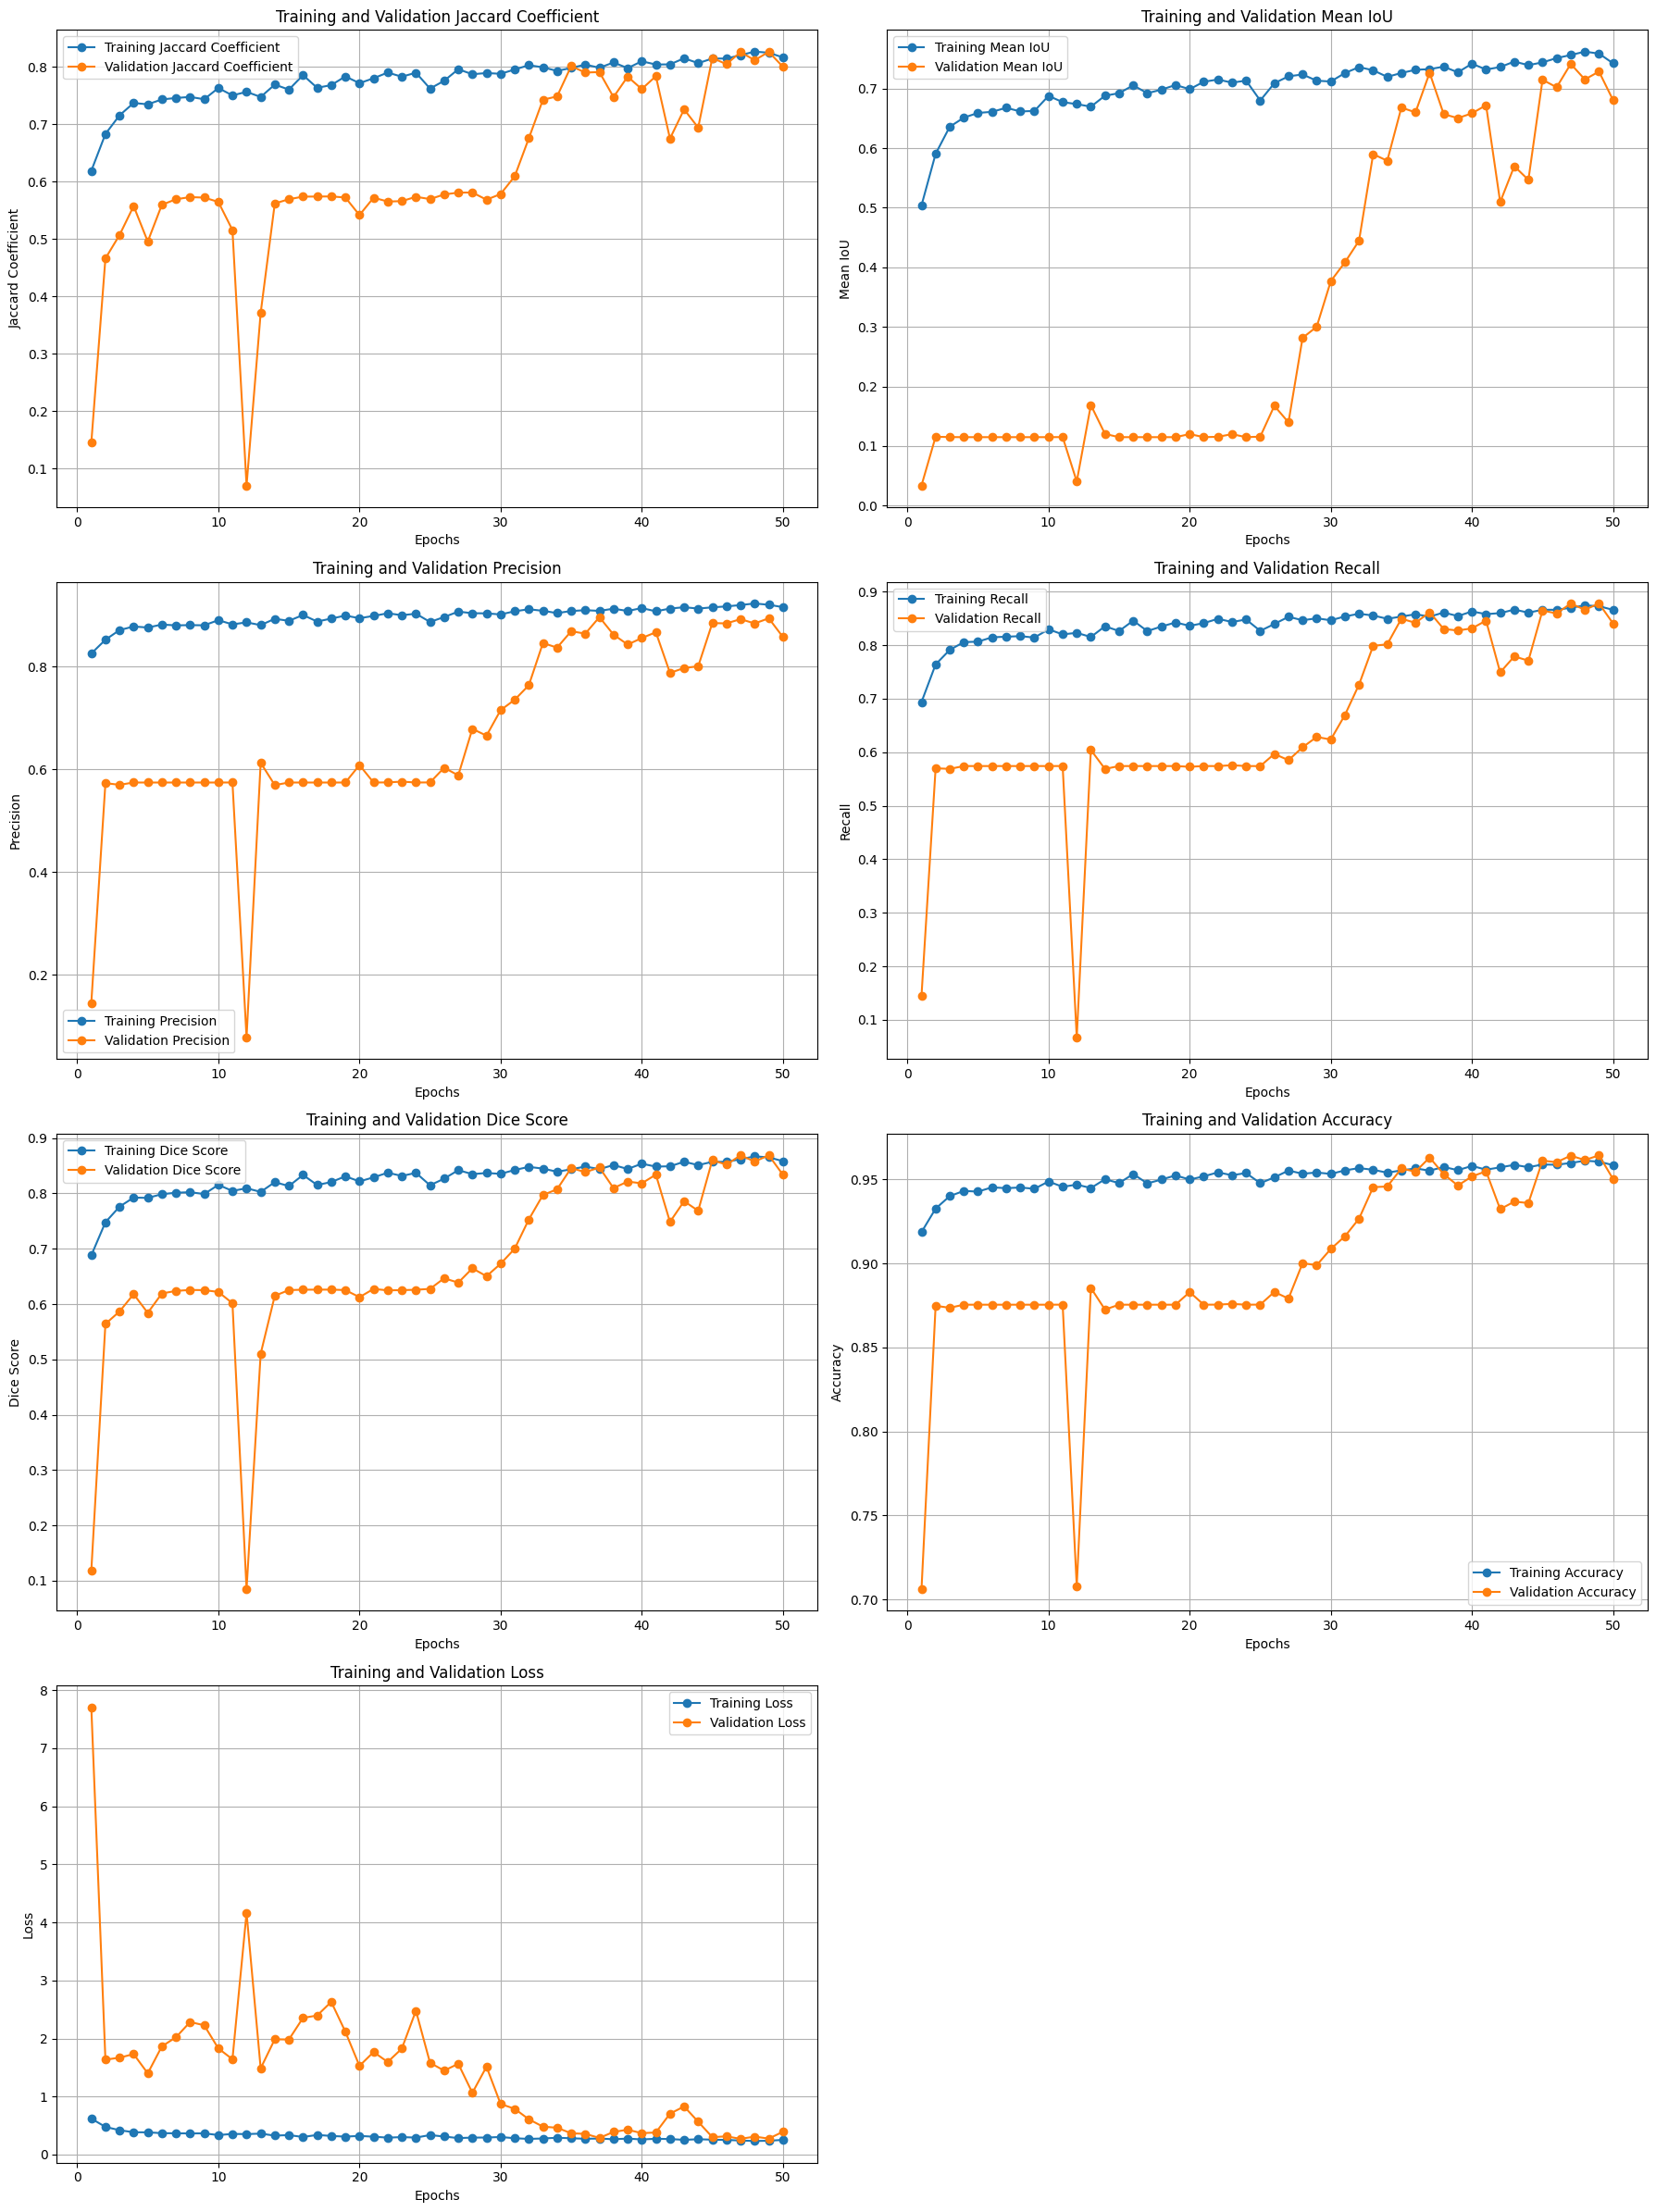

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(18, 24))
    
    # Jaccard Coefficient
    plt.subplot(4, 2, 1)
    plt.plot(epochs, history.history['jaccard_coeff'], label='Training Jaccard Coefficient', marker= 'o')
    plt.plot(epochs, history.history['val_jaccard_coeff'],  label='Validation Jaccard Coefficient', marker= 'o')
    plt.title('Training and Validation Jaccard Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard Coefficient')
    plt.legend()
    plt.grid()

    # Mean IoU
    plt.subplot(4, 2, 2)
    plt.plot(epochs, history.history['one_hot_io_u_1'],  label='Training Mean IoU', marker= 'o')
    plt.plot(epochs, history.history['val_one_hot_io_u_1'],  label='Validation Mean IoU', marker= 'o')
    plt.title('Training and Validation Mean IoU')
    plt.xlabel('Epochs')
    plt.ylabel('Mean IoU')
    plt.legend()
    plt.grid()

    # Precision
    plt.subplot(4, 2, 3)
    plt.plot(epochs, history.history['precision_2'],  label='Training Precision', marker= 'o')
    plt.plot(epochs, history.history['val_precision_2'],  label='Validation Precision', marker= 'o')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()

    # Recall
    plt.subplot(4, 2, 4)
    plt.plot(epochs, history.history['recall_2'],  label='Training Recall', marker= 'o')
    plt.plot(epochs, history.history['val_recall_2'],  label='Validation Recall', marker= 'o')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid()

    # Dice Score
    plt.subplot(4, 2, 5)
    plt.plot(epochs, history.history['dice_score'],  label='Training Dice Score', marker= 'o')
    plt.plot(epochs, history.history['val_dice_score'],  label='Validation Dice Score', marker= 'o')
    plt.title('Training and Validation Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(4, 2, 6)
    plt.plot(epochs, history.history['segmentation_accuracy'],  label='Training Accuracy', marker= 'o')
    plt.plot(epochs, history.history['val_segmentation_accuracy'],  label='Validation Accuracy', marker= 'o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(4, 2, 7)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker= 'o')
    plt.plot(epochs, history.history['val_loss'],  label='Validation Loss', marker= 'o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_training_history(history)

In [18]:
# Evaluate the model
deeplabv3plus_model.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - dice_score: 0.8043 - jaccard_coeff: 0.7621 - loss: 0.4662 - one_hot_io_u_1: 0.6786 - precision_2: 0.8420 - recall_2: 0.8228 - segmentation_accuracy: 0.9446


[0.4472077190876007,
 0.6849215626716614,
 0.846329391002655,
 0.8279217481613159,
 0.7698923349380493,
 0.8118788599967957,
 0.9459840655326843]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


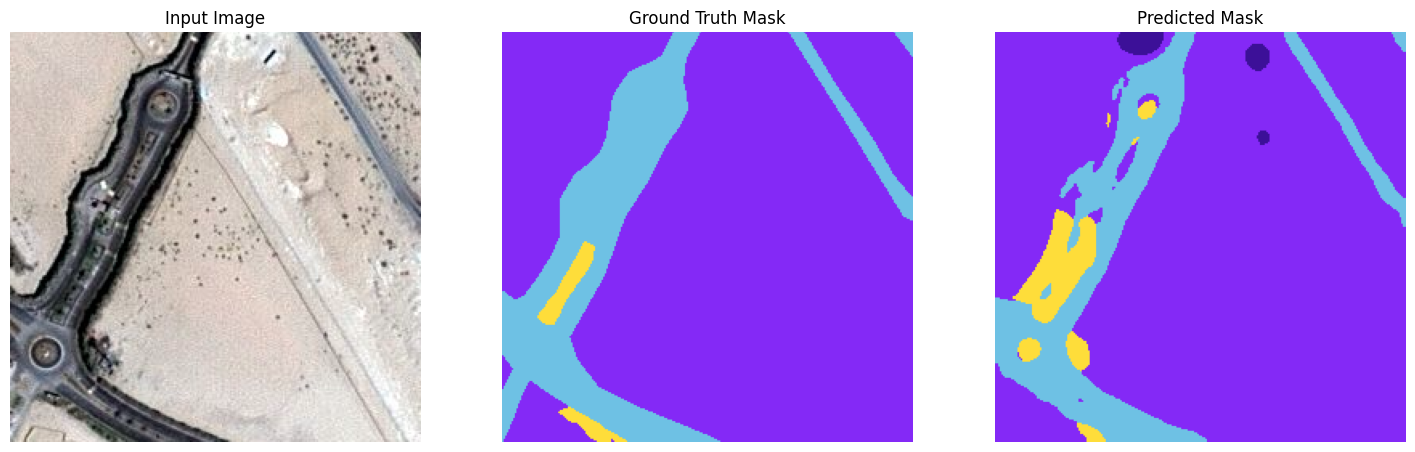

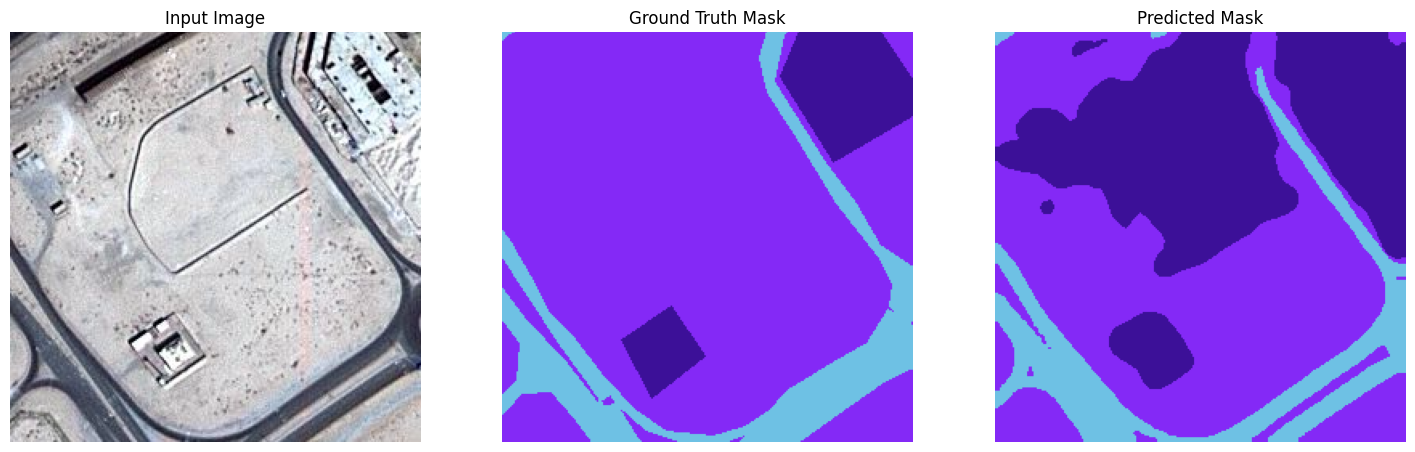

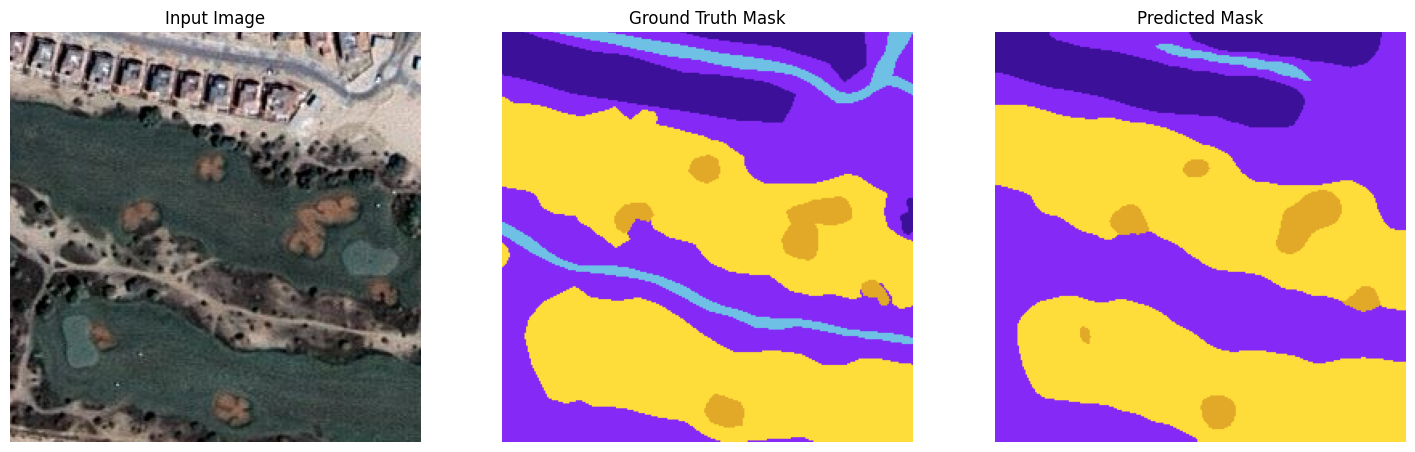

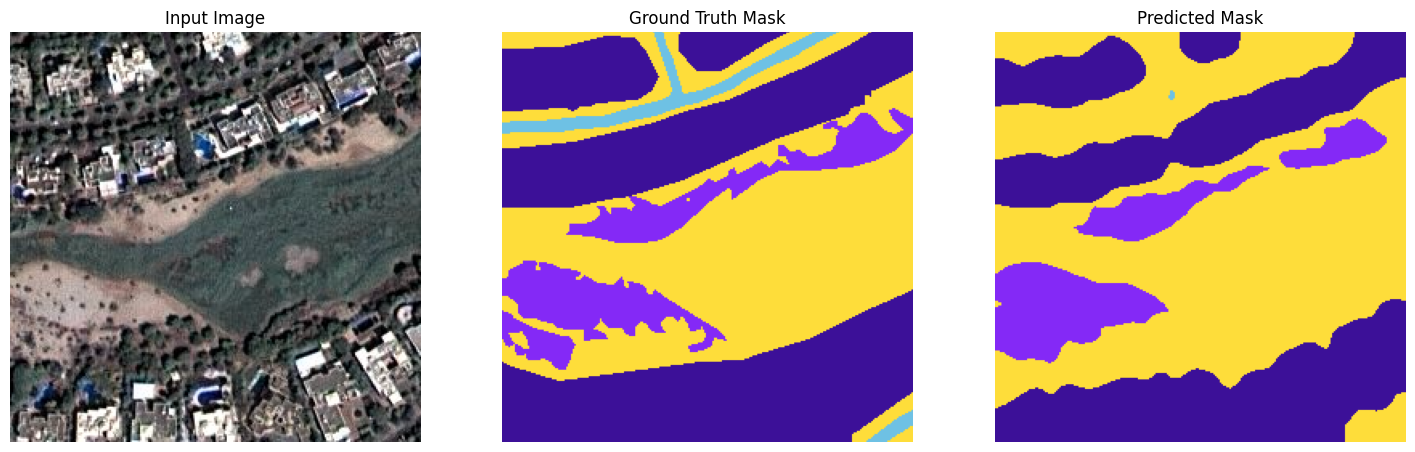

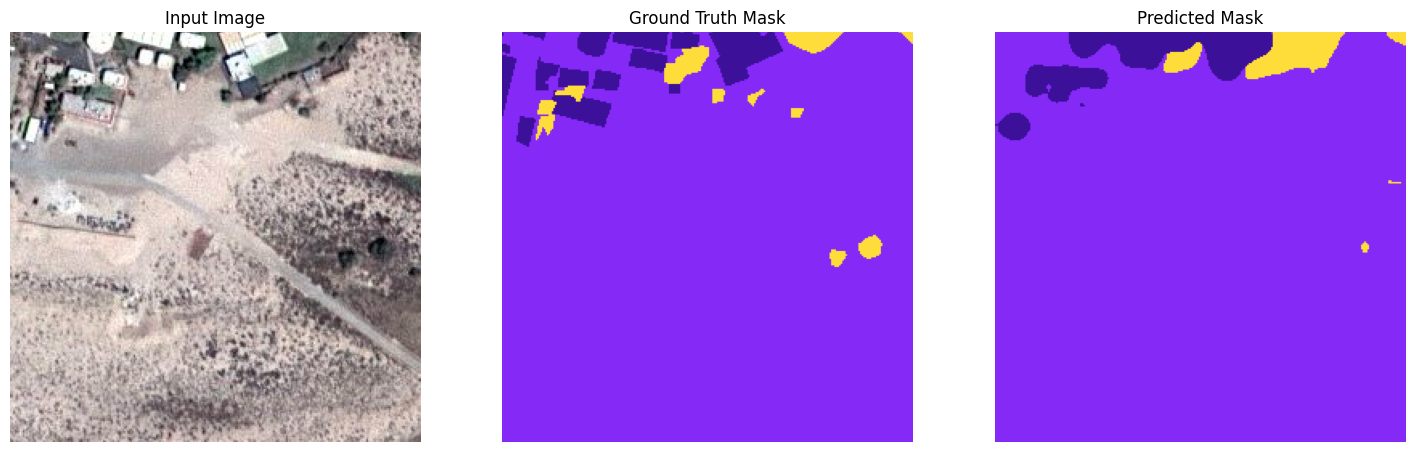

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Select a batch of test images to predict
num_samples = 5  # Number of samples to display
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
test_images = X_test[sample_indices]
test_masks = y_test[sample_indices]

# Generate predictions
predicted_masks = deeplabv3plus_model.predict(test_images)

# Define a function to map class indices to RGB colors
def decode_mask(mask, color_dict):
    decoded_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_index, color in color_dict.items():
        decoded_mask[mask == class_index] = color
    return decoded_mask

# Map class index to RGB color (make sure this dictionary matches your classes)
class_colors_rgb = {
    0: (60, 16, 152),    # Building
    1: (132, 41, 246),   # Land
    2: (110, 193, 228),  # Road
    3: (254, 221, 58),   # Vegetation
    4: (226, 169, 41),   # Water
    5: (155, 155, 155)   # Unlabeled
}

# Display the results
for i in range(num_samples):
    fig, ax = plt.subplots(1, 3, figsize=(18, 8))
    
    # Display input image
    ax[0].imshow(test_images[i])
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    # Display ground truth mask
    true_mask = np.argmax(test_masks[i], axis=-1)  # Convert one-hot to label indices
    decoded_true_mask = decode_mask(true_mask, class_colors_rgb)
    ax[1].imshow(decoded_true_mask)
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis("off")

    # Display predicted mask
    pred_mask = np.argmax(predicted_masks[i], axis=-1)  # Convert one-hot to label indices
    decoded_pred_mask = decode_mask(pred_mask, class_colors_rgb)
    ax[2].imshow(decoded_pred_mask)
    ax[2].set_title("Predicted Mask")
    ax[2].axis("off")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


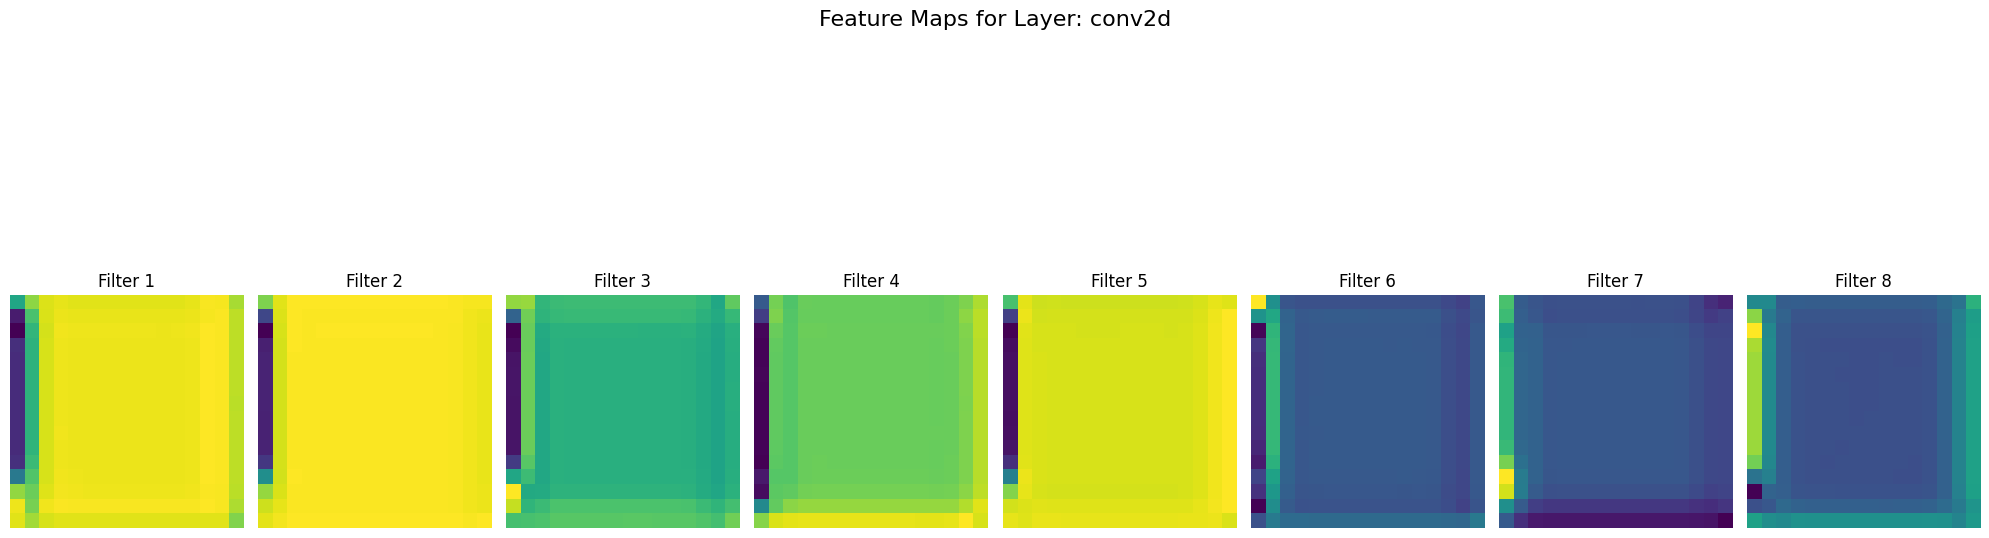

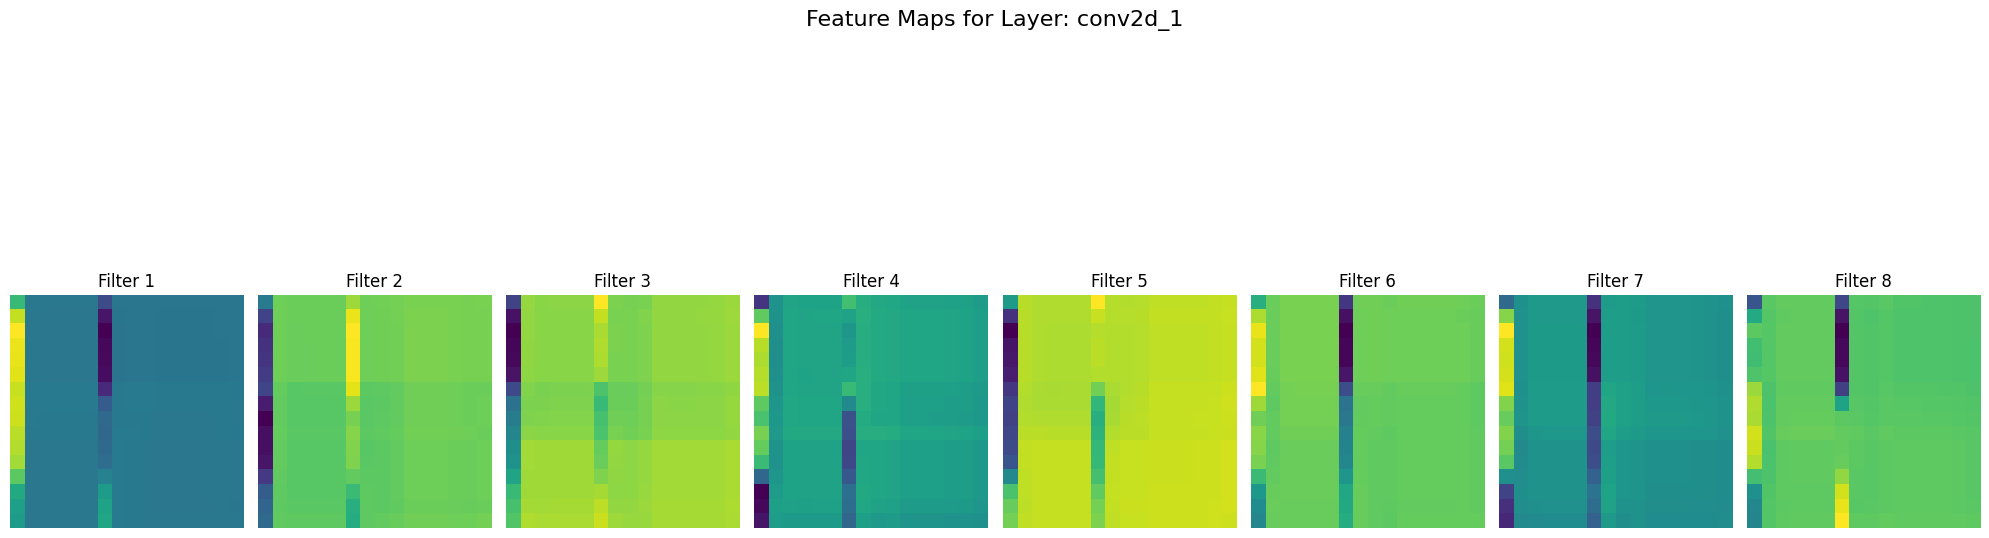

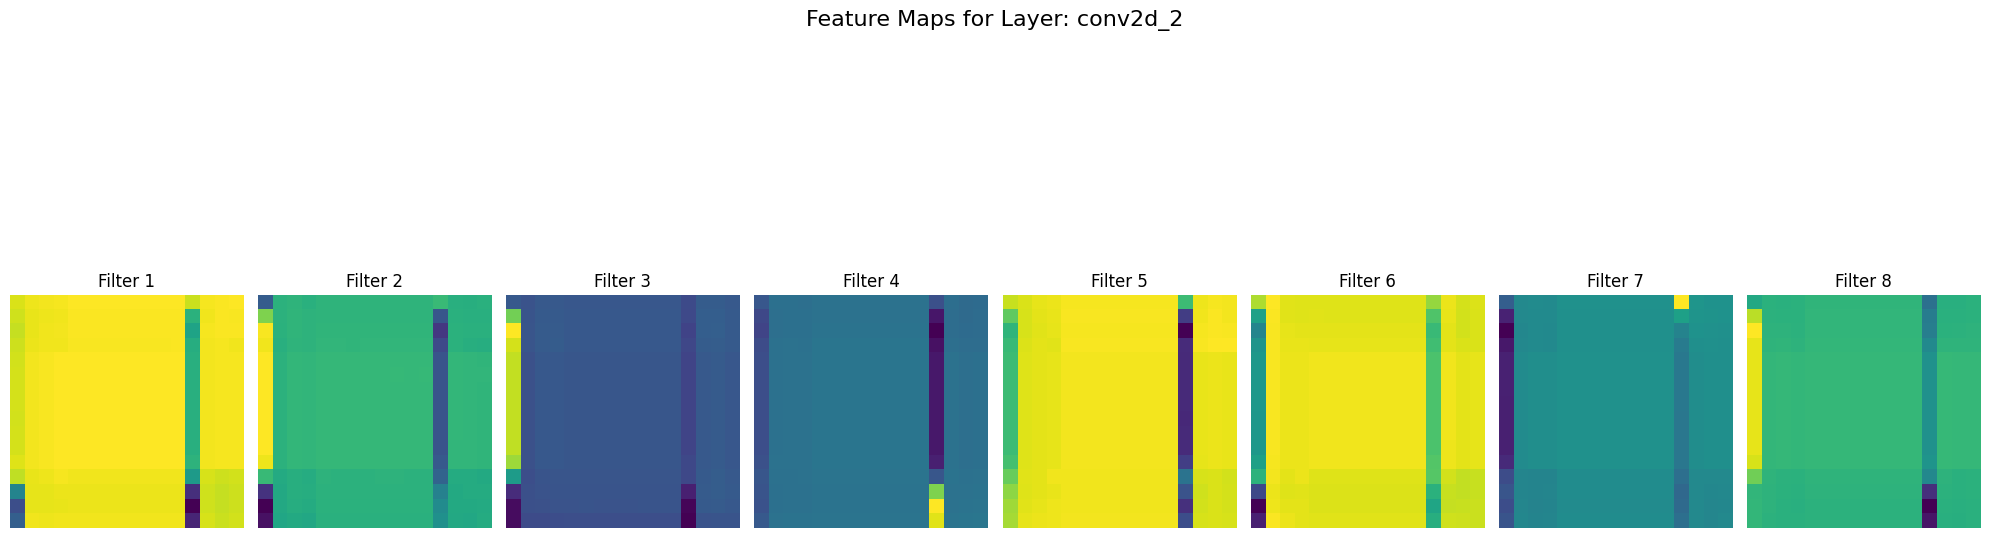

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Function to plot feature maps
def plot_feature_maps(model, input_image, layer_names=None):
    """
    Visualizes feature maps from specific layers of a Keras model.

    Parameters:
    - model: Keras model.
    - input_image: Image input for generating feature maps (should be preprocessed).
    - layer_names: List of layer names to visualize. If None, all Conv2D layers are used.
    """
    if layer_names is None:
        # Automatically select all Conv2D layers if layer_names is not provided
        layer_names = [layer.name for layer in model.layers if isinstance(layer, Model)]

    # Create a sub-model that outputs the layers specified in layer_names
    outputs = [model.get_layer(name).output for name in layer_names]
    feature_model = Model(inputs=model.input, outputs=outputs)

    # Generate feature maps
    feature_maps = feature_model.predict(np.expand_dims(input_image, axis=0))

    for layer_name, feature_map in zip(layer_names, feature_maps):
        num_filters = feature_map.shape[-1]  # Number of filters
        size = feature_map.shape[1]         # Width/Height of feature map

        # Plot each filter in the feature map
        fig, axes = plt.subplots(1, min(num_filters, 8), figsize=(20, 8))
        fig.suptitle(f"Feature Maps for Layer: {layer_name}", fontsize=16)

        for i in range(min(num_filters, 8)):  # Visualize at most 8 filters
            axes[i].imshow(feature_map[0, :, :, i], cmap='viridis')
            axes[i].axis('off')
            axes[i].set_title(f"Filter {i+1}")

        plt.tight_layout()
        plt.show()

# Load or preprocess an image from your dataset
# Replace this with actual preprocessing specific to your model
sample_image = X_test[0]  # Replace X_test with your dataset
sample_image = sample_image / 255.0  # Normalization (if required)

# Call the function to visualize feature maps
# Replace `model` with your actual model instance
layer_names_to_visualize = ['conv2d', 'conv2d_1', 'conv2d_2']  # Example layers to visualize
plot_feature_maps(deeplabv3plus_model, sample_image, layer_names_to_visualize)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


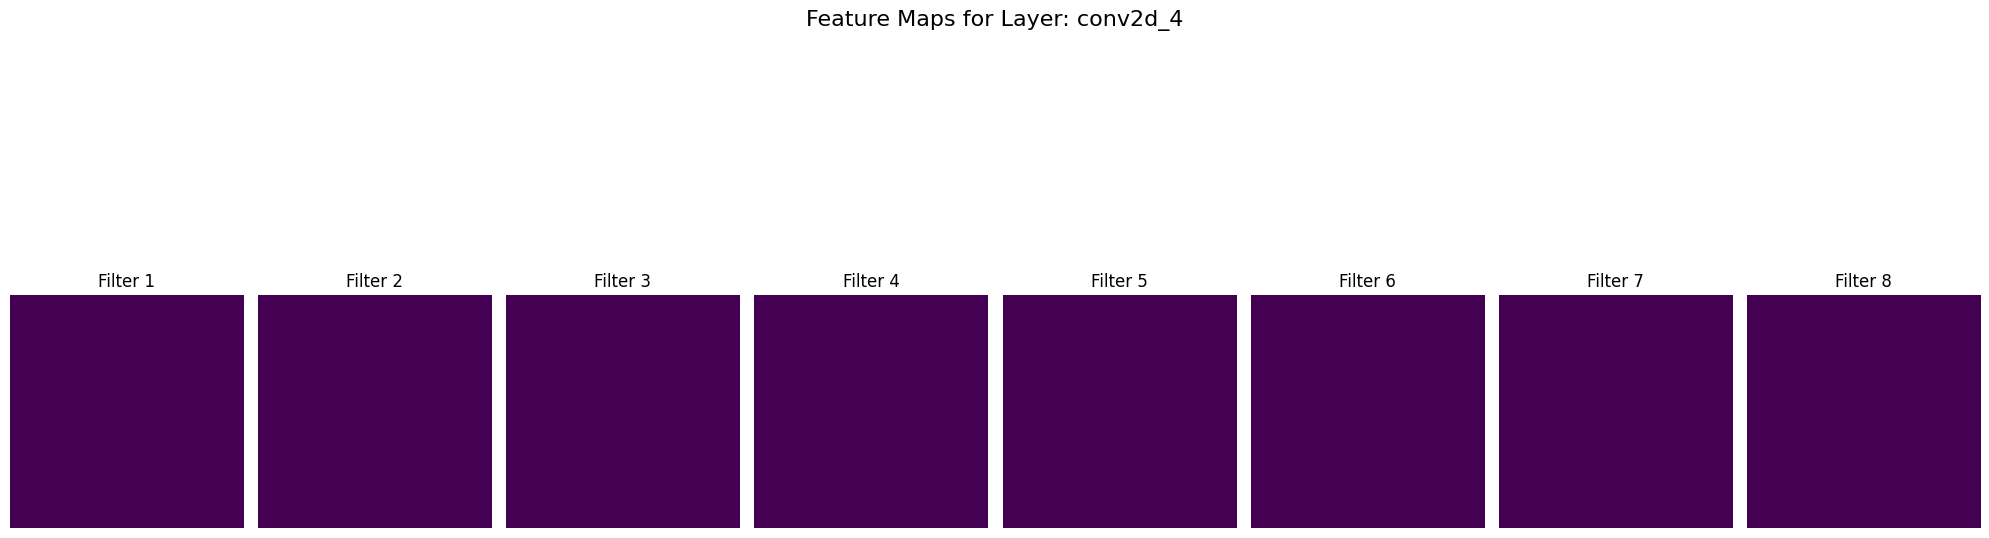

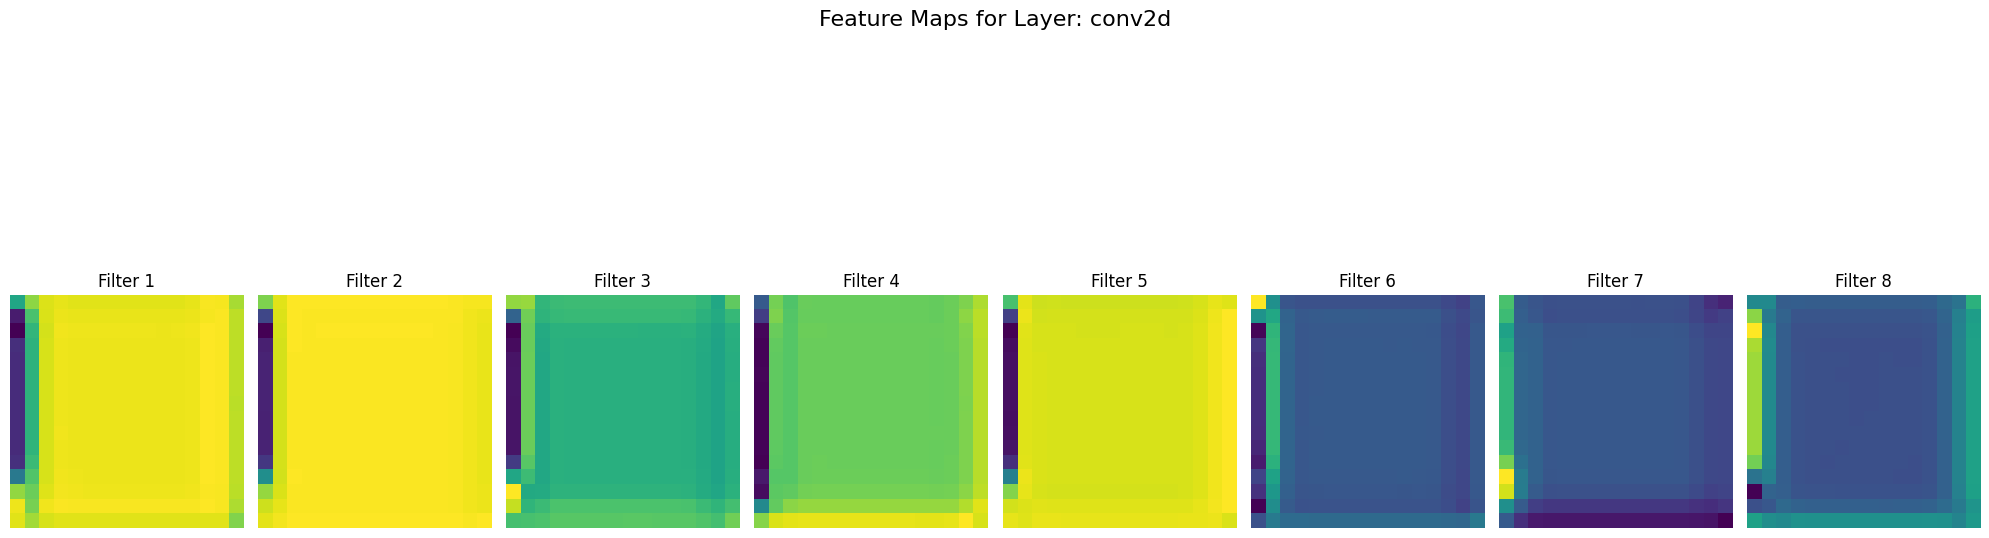

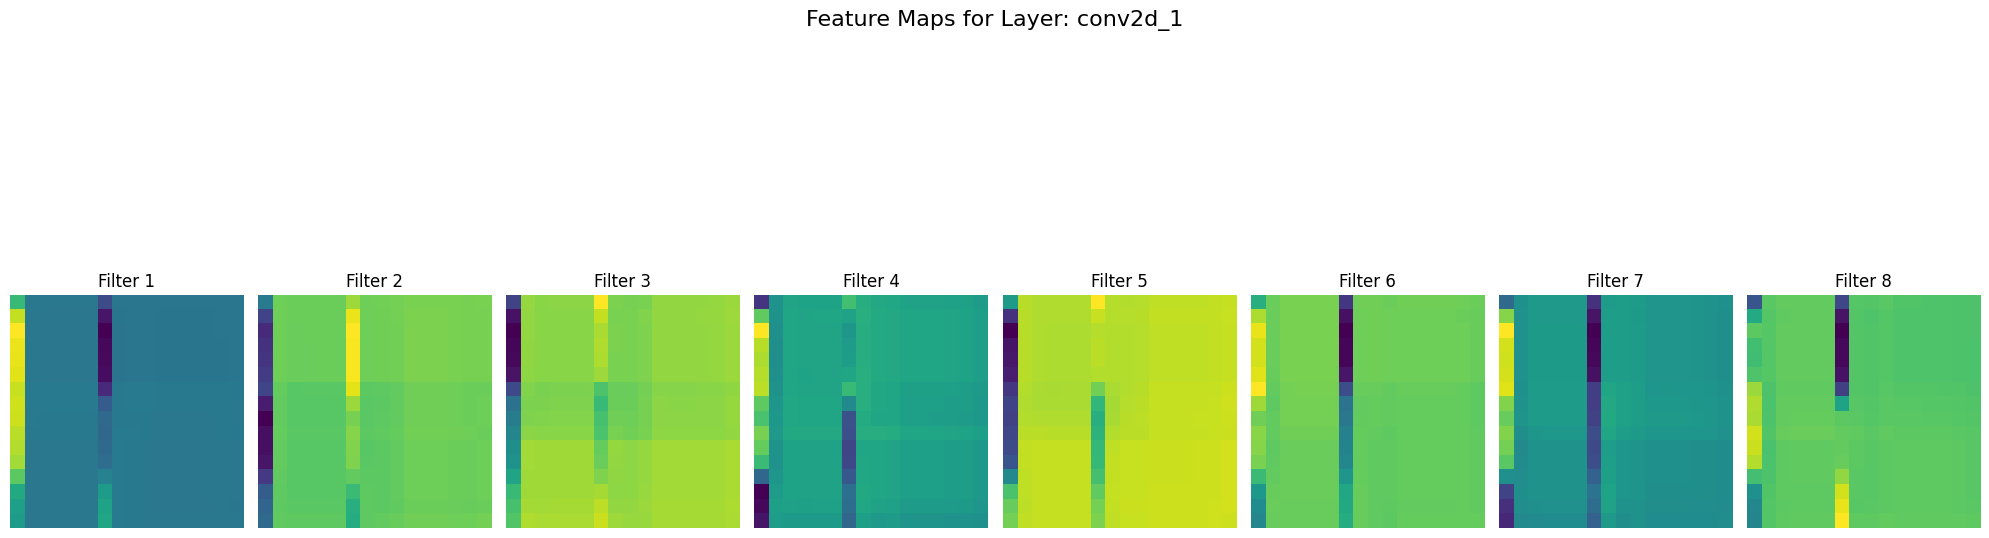

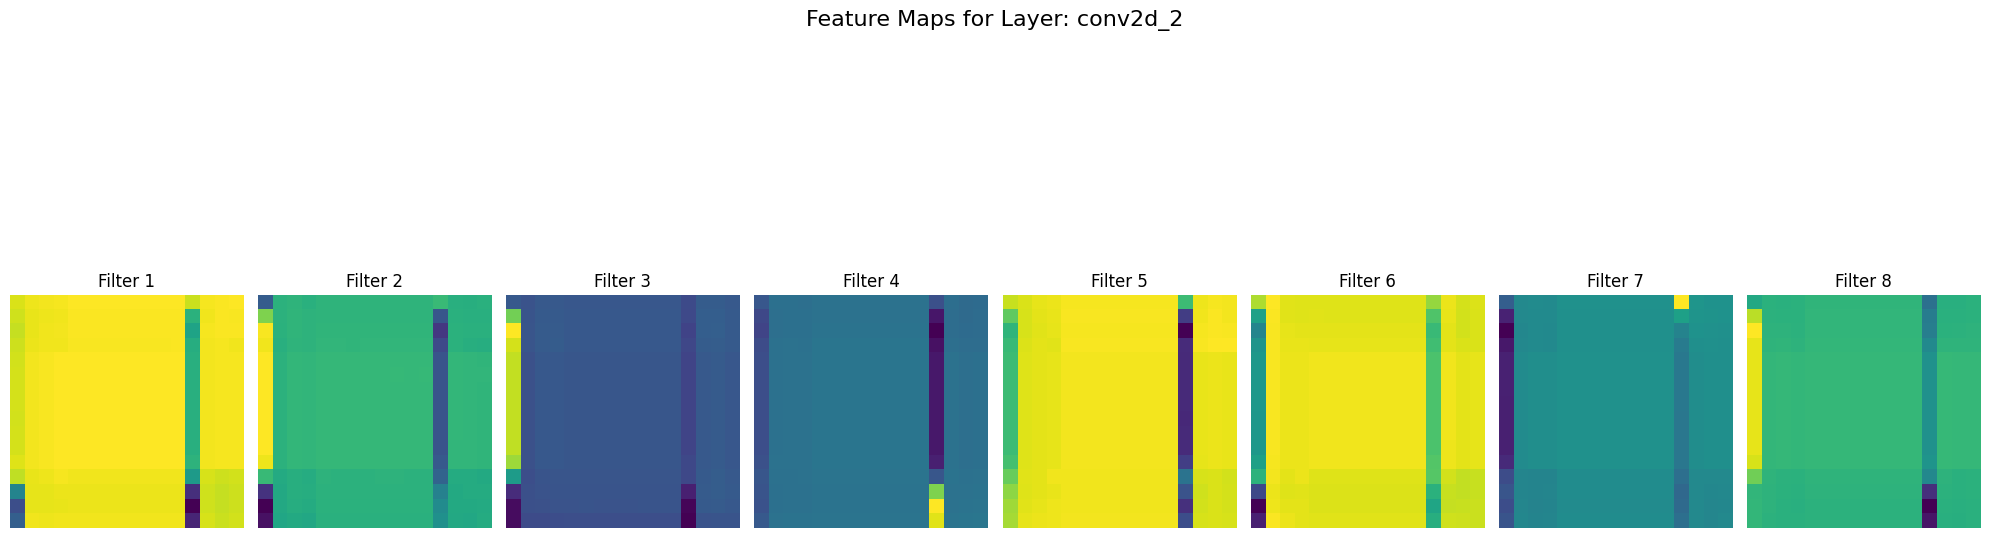

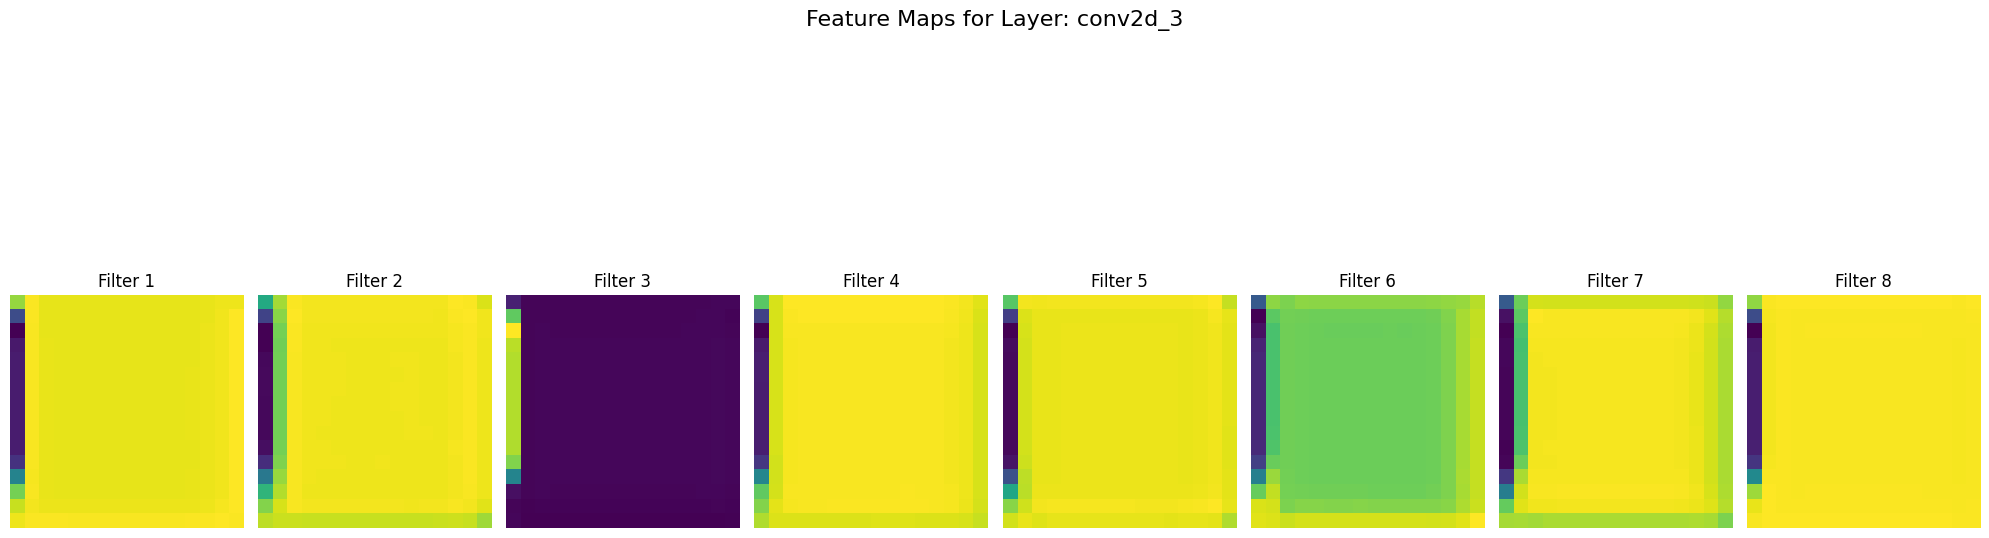

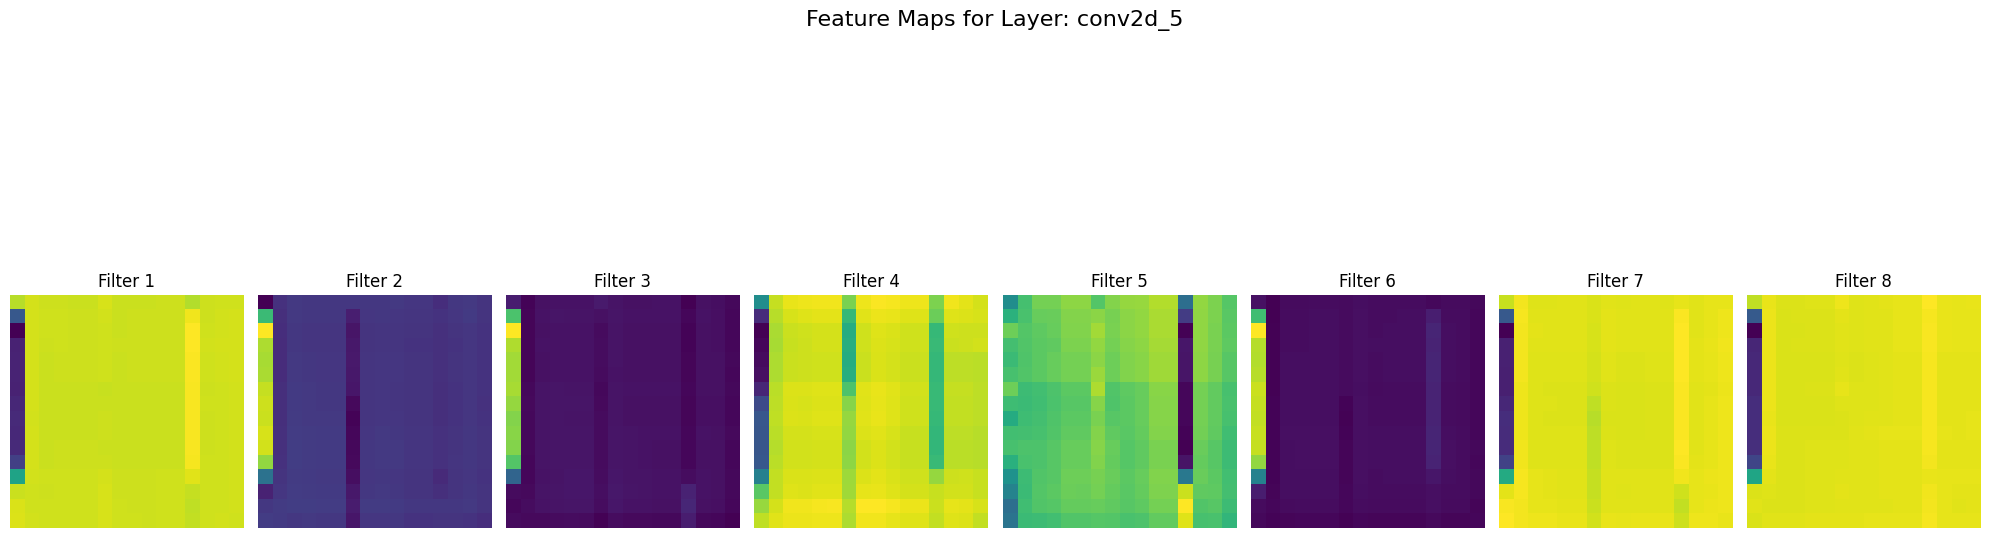

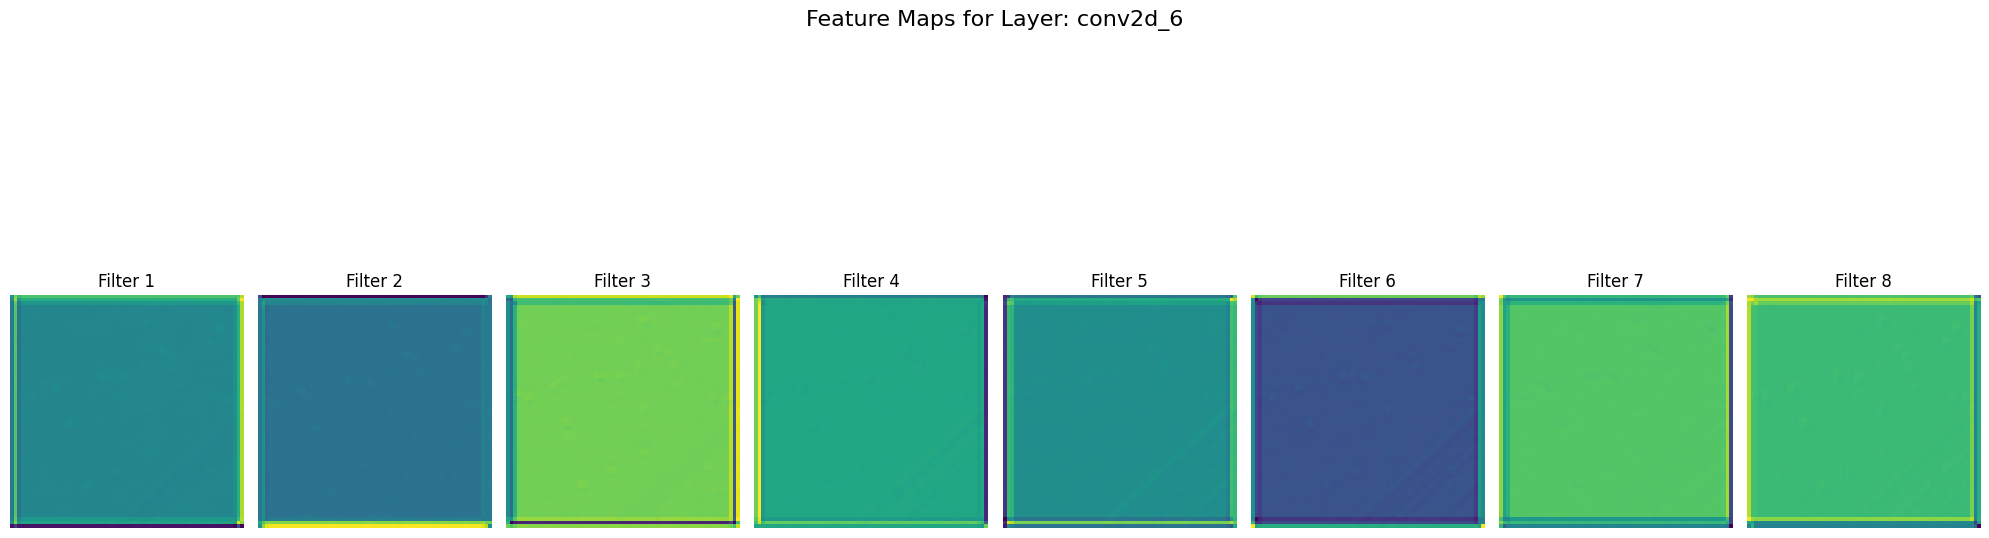

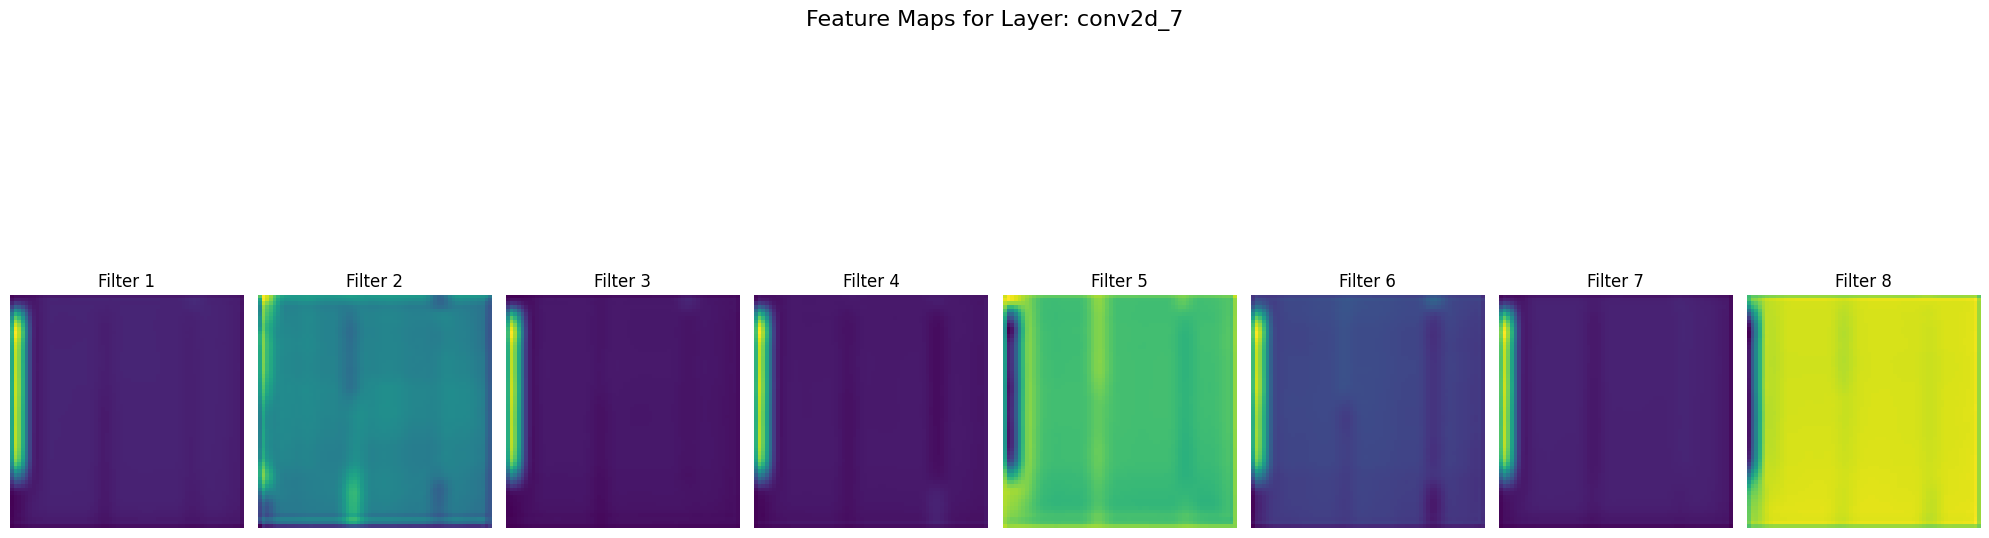

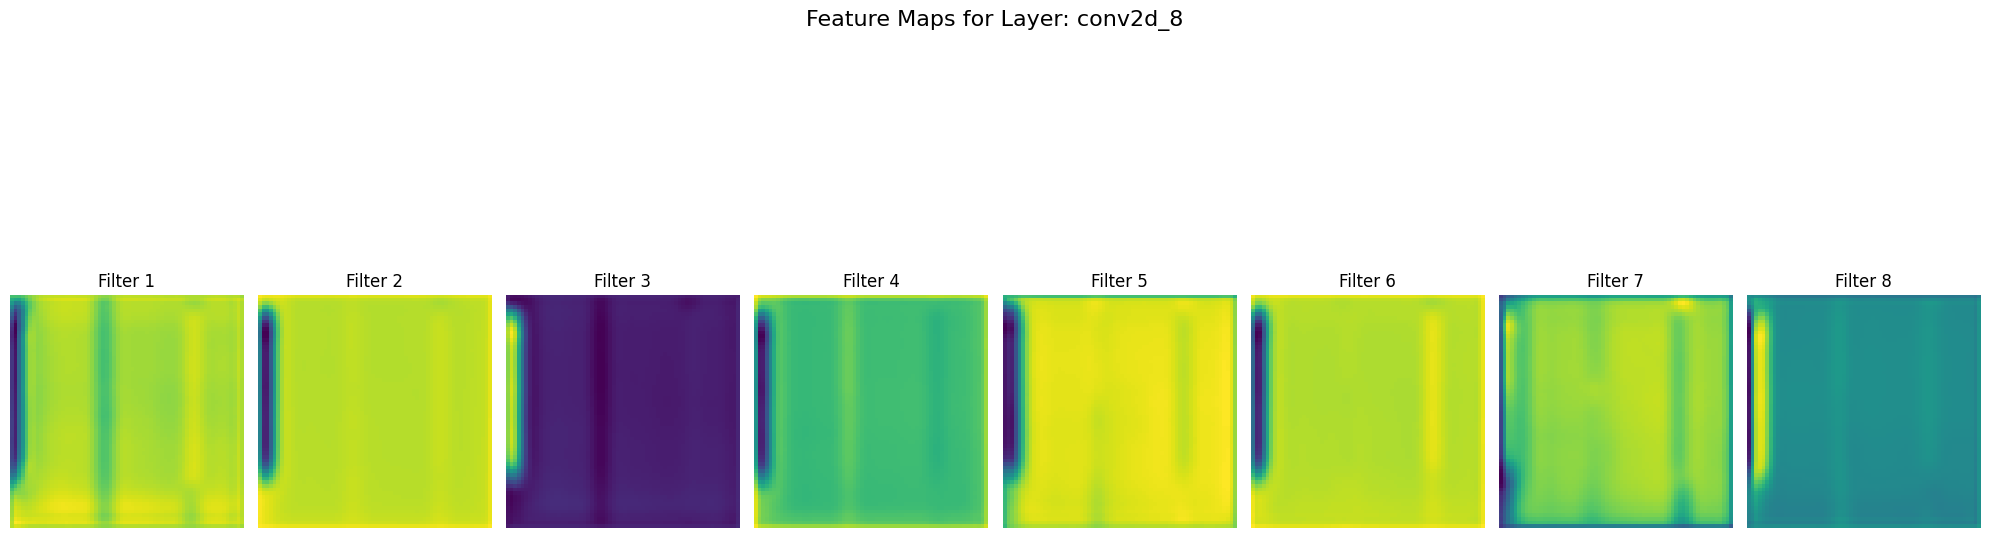

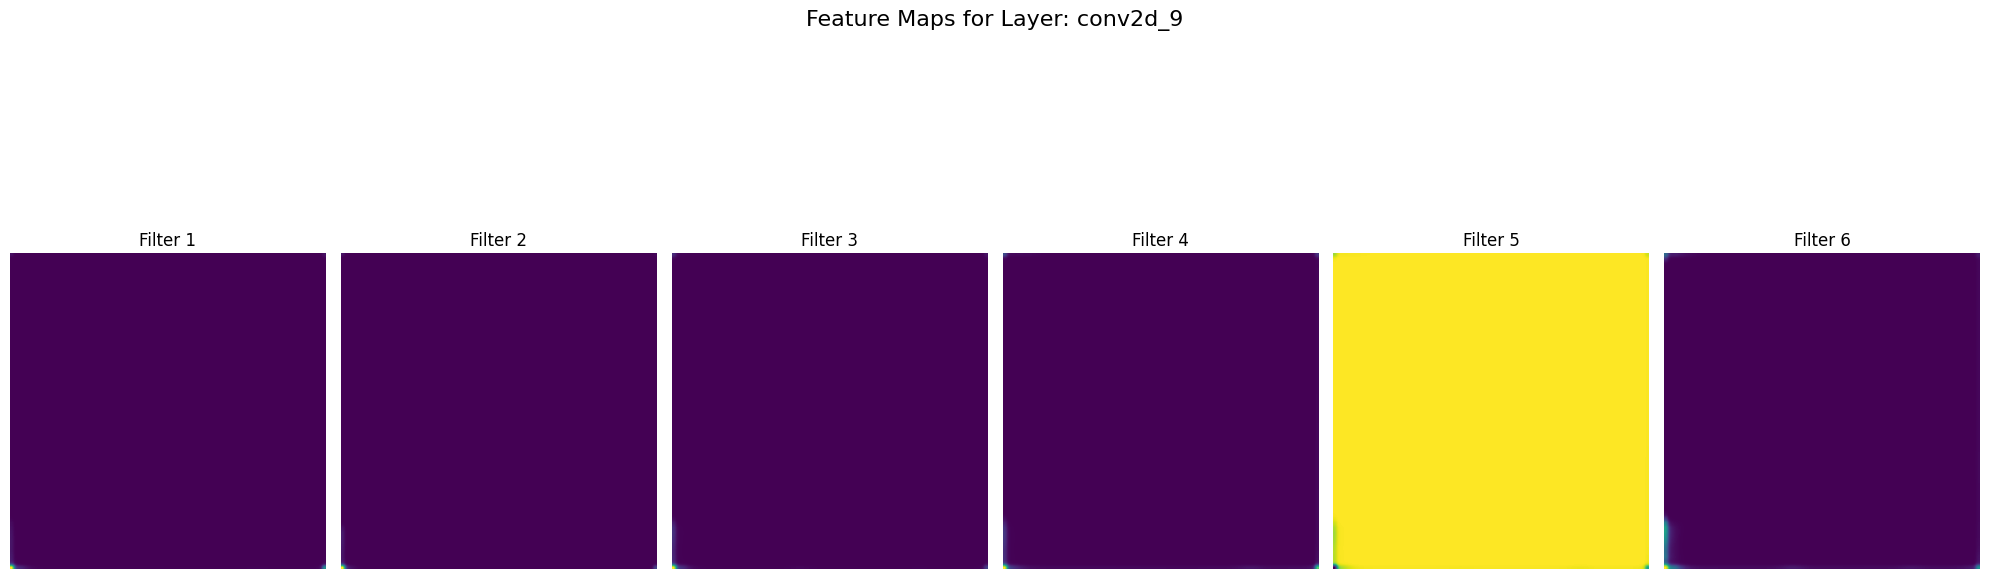

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def plot_feature_maps_all_layers(model, input_image):
    """
    Visualizes feature maps of all Conv2D layers in the model for a given input image.

    Parameters:
    - model: Keras model instance.
    - input_image: Image input for generating feature maps (preprocessed).
    """
    # Get outputs of layers that contain 'conv2d' or 'conv2d_transpose'
    layer_outputs = [layer.output for layer in model.layers if 'conv2d' in layer.name or 'conv2d_transpose' in layer.name]

    # Create a new model to output the intermediate layer feature maps
    feature_model = Model(inputs=model.input, outputs=layer_outputs)

    # Generate feature maps
    feature_maps = feature_model.predict(np.expand_dims(input_image, axis=0))

    # Iterate through the feature maps and visualize
    for layer_name, feature_map in zip(
        [layer.name for layer in model.layers if 'conv2d' in layer.name or 'conv2d_transpose' in layer.name],
        feature_maps,
    ):
        num_filters = feature_map.shape[-1]  # Number of filters
        size = feature_map.shape[1]         # Width/Height of feature map

        # Plot each filter in the feature map
        fig, axes = plt.subplots(1, min(num_filters, 8), figsize=(20, 8))
        fig.suptitle(f"Feature Maps for Layer: {layer_name}", fontsize=16)

        for i in range(min(num_filters, 8)):  # Visualize at most 8 filters
            axes[i].imshow(feature_map[0, :, :, i], cmap='viridis')
            axes[i].axis('off')
            axes[i].set_title(f"Filter {i+1}")

        plt.tight_layout()
        plt.show()

# Load or preprocess an image from your dataset
# Replace this with actual preprocessing specific to your model
sample_image = X_test[0]  # Replace X_test with your dataset
sample_image = sample_image / 255.0  # Normalization (if required)

# Call the function to visualize feature maps
plot_feature_maps_all_layers(deeplabv3plus_model, sample_image)


# building a model using segmentation-models library

In [ ]:
# !pip install segmentation-models==1.0.1
# !pip install efficientnet==1.0.0

# # run this cell to make sure keras is compatible with segmentation_models 
# with open('/opt/conda/lib/python3.10/site-packages/efficientnet/__init__.py', 'r') as file:
#     file_data = file.readlines()

# # Modify the line that causes the error
# for i, line in enumerate(file_data):
#     if 'keras.utils.generic_utils.get_custom_objects().update(custom_objects)' in line:
#         file_data[i] = line.replace('keras.utils.generic_utils', 'keras.utils')

# with open('/opt/conda/lib/python3.10/site-packages/efficientnet/__init__.py', 'w') as file:
#     file.writelines(file_data)


# # Check
# file_path = '/opt/conda/lib/python3.10/site-packages/efficientnet/__init__.py'
# with open(file_path, 'r') as file:
#     file_data = file.readlines()

# # Search for 'generic_utils'
# found = False
# for line in file_data:
#     if 'generic_utils' in line:
#         found = True
#         print(f"'generic_utils' found in line: {line.strip()}")

# if not found:
#     print("No instances of 'generic_utils' found in the file.")


# import segmentation_models as sm
# from segmentation_models import Unet


# from segmentation_models import get_preprocessing
# BACKBONE = 'resnet18'
# preprocess_input = get_preprocessing(BACKBONE)

# X_train = preprocess_input(X_train)
# X_test = preprocess_input(X_test)


# # Load pre-trained U-Net model 
# base_model = Unet(BACKBONE, encoder_weights='imagenet', activation = 'softmax', classes=num_classes)

# compile and then train the model as usual 